Import Needed Modules

In [832]:
import re  #regular expressions
import pandas as pd   # for dataframes
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.svm import SVC





Import raw code

In [834]:
filepath = "/Users/davidcaspers/Downloads/trawlers.csv"
df = pd.read_csv(filepath)
df.head()

mmsi     timestamp  distance_from_shore  distance_from_port  speed  \
0  1.252340e+12  1.325376e+09                  0.0                 0.0    0.0   
1  1.252340e+12  1.325378e+09                  0.0                 0.0    0.0   
2  1.252340e+12  1.325379e+09                  0.0                 0.0    0.0   
3  1.252340e+12  1.325380e+09                  0.0                 0.0    0.0   
4  1.252340e+12  1.325381e+09                  0.0                 0.0    0.0   

   course        lat       lon  is_fishing source  
0   153.0  52.458649  4.581200        -1.0    gfw  
1   153.0  52.458668  4.581167        -1.0    gfw  
2   153.0  52.458633  4.581183        -1.0    gfw  
3   153.0  52.458649  4.581234        -1.0    gfw  
4   153.0  52.458649  4.581183        -1.0    gfw

See the distribution of the labels

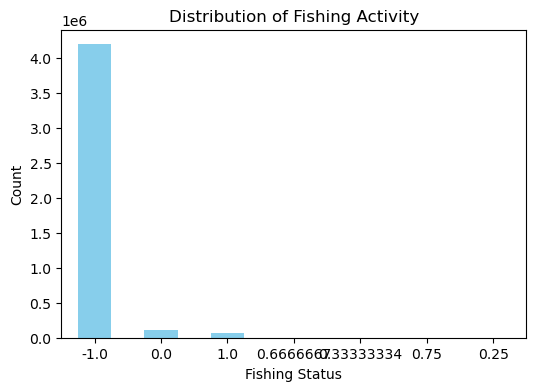

In [836]:
#Plot the distribution of is_fishing:
fishing_distribution = df['is_fishing'].value_counts()

plt.figure(figsize=(6, 4))
fishing_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Fishing Activity')
plt.xlabel('Fishing Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Drop the values equal to -1 as these are unlabeled; round values between 0 and 1 to 1 (these labels are ones that there was disagreement on whether the vessels were fishing.

Replot the Label Distribution

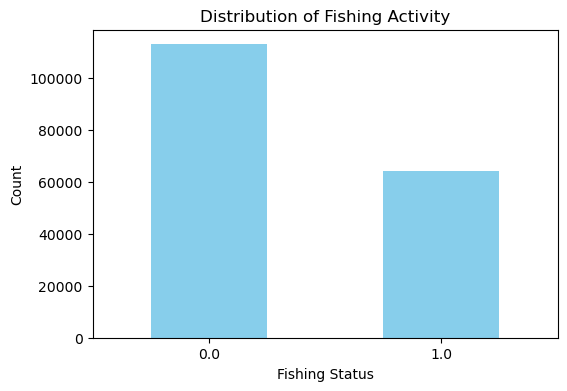

In [838]:
#Drop -1.0 values as they are unlabled
df = df[df['is_fishing']!= -1]
fishing_distribution = df['is_fishing'].value_counts()

#relable any values >0 as 1.0 as false positives are better than false negatives in this case
df['is_fishing'] = df['is_fishing'].apply(lambda x: 1.0 if x > 0 else x)
fishing_distribution = df['is_fishing'].value_counts()

plt.figure(figsize=(6, 4))
fishing_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Fishing Activity')
plt.xlabel('Fishing Status')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.show()

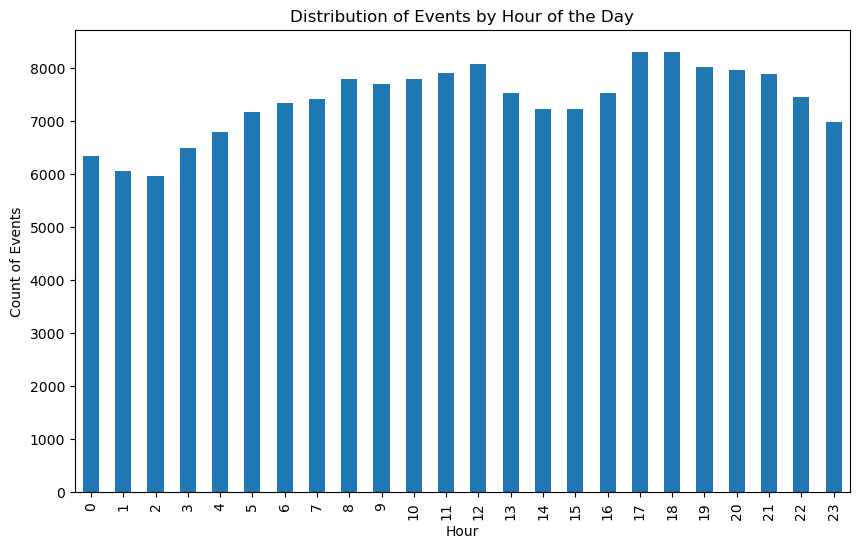

In [839]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')  # Convert from Unix timestamp
# Extract the hour from the timestamp
df['hour'] = df['timestamp'].dt.hour

# Plot a histogram of events by hour
plt.figure(figsize=(10, 6))
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Events by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Count of Events')
plt.show()

In [840]:
# Get the minimum and maximum dates in the 'timestamp' column
min_date = df['timestamp'].min()
max_date = df['timestamp'].max()

print(f"Date range: {min_date} to {max_date}")

Date range: 2012-01-01 09:21:55 to 2016-04-15 05:22:41


In [841]:
#Using geopands convert lon and lat to points
df_geo = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat))

#map needs crs added to correctly plot . . . assuming standard latitude and longitude coordinates (WGS84)
df_geo = df_geo.set_crs(epsg=4326, allow_override=True)

# Convert the mmsi column to integers if it's in scientific notation
df_geo['mmsi'] = df_geo['mmsi'].astype('int64')

df_geo['timestamp'] = pd.to_datetime(df_geo['timestamp'], unit='s')  # Convert from Unix timestamp


Convert the plot to geometry panda frame:

Plot the data-Points

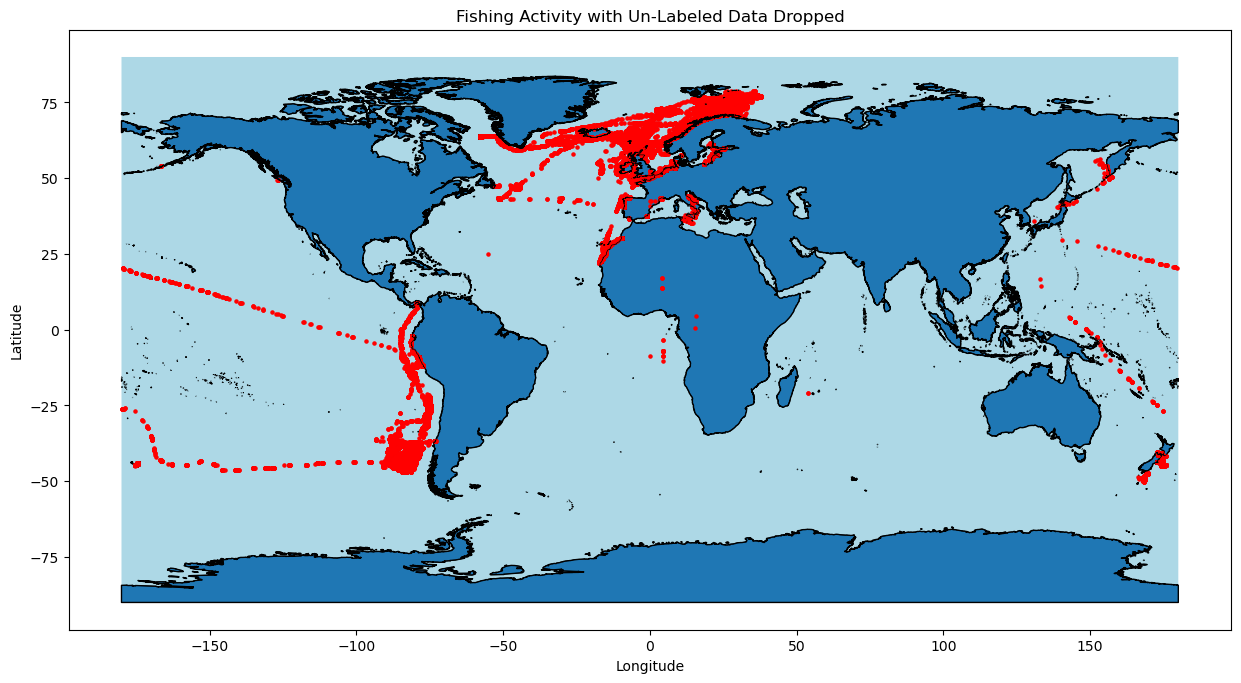

In [844]:
# Load the map layers
coastlines = gpd.read_file('/Users/davidcaspers/Downloads/ne_10m_coastline/ne_10m_coastline.shp')
land = gpd.read_file('/Users/davidcaspers/Downloads/ne_10m_land/ne_10m_land.shp')
minor_islands = gpd.read_file('/Users/davidcaspers/Downloads/ne_10m_minor_islands/ne_10m_minor_islands.shp')
ocean = gpd.read_file('/Users/davidcaspers/Downloads/ne_10m_ocean/ne_10m_ocean.shp')

# Plot each layer
fig, ax = plt.subplots(figsize=(15, 10))

# Plot ocean first (if you want ocean boundaries)
ocean.plot(ax=ax, color='lightblue')

# Plot land
land.plot(ax=ax, edgecolor='black')

# Plot minor islands
minor_islands.plot(ax=ax, color='green', edgecolor='black')

# Plot coastlines on top
coastlines.plot(ax=ax, color='black', linewidth=0.5)

# Overlay the fishing data
df_geo.plot(ax=ax, marker='o', color='red', markersize=5)

# Add labels and title
plt.title('Fishing Activity with Un-Labeled Data Dropped')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

Tried to plot these at trips by looking at when the ships came and left port + had gaps >12hrs of transmission but the majority of the dataset was not properly broken up. Breaking up into discrete trips is not going to be feasible for this.

Further filter the dataset by looking for times where the ship transmitted but was still in port:

Text(0, 0.5, 'Distance From Port')

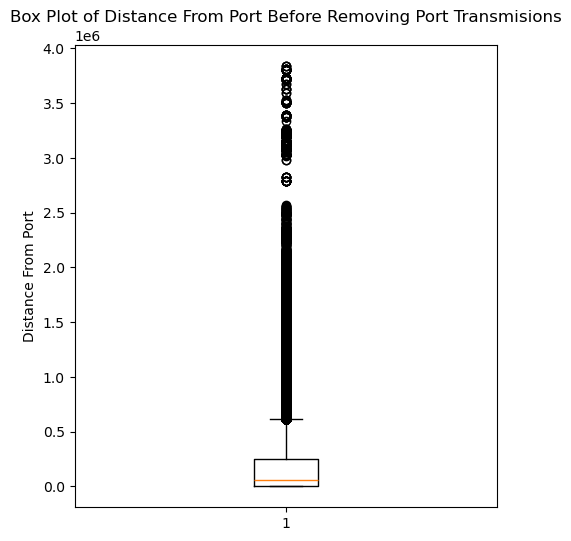

In [846]:
# Box plot before cleaning
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(df_geo['distance_from_port'])
plt.title('Box Plot of Distance From Port Before Removing Port Transmisions')
plt.ylabel('Distance From Port')


In [847]:
print(f"Mean Distance From Port Before Removing Port Transmissions: {df_geo['distance_from_port'].mean()}")
print(f"Variance, Distance From Port Before Removing Port Transmissions: {df_geo['distance_from_port'].var()}")

Mean Distance From Port Before Removing Port Transmissions: 274428.868050333
Variance, Distance From Port Before Removing Port Transmissions: 227832127445.7288


In [848]:
# Sort the dataframe by 'mmsi' and 'timestamp' to ensure proper row order within each ship
df_geo = df_geo.sort_values(by=['mmsi', 'timestamp'])

# Define a function to find and drop rows where the ship was transmitting while in port
def drop_transmitting_in_port(group):
    # Shift the distance_from_port column to get the previous and next values
    group['prev_distance_from_port'] = group['distance_from_port'].shift(1)
    group['next_distance_from_port'] = group['distance_from_port'].shift(-1)
    
    # Identify rows where the ship was in port (i.e., distance_from_port == 0) 
    # and both the previous and next values also have distance_from_port == 0
    rows_to_drop = group[
        (group['distance_from_port'] == 0) &
        (group['prev_distance_from_port'] == 0) &
        (group['next_distance_from_port'] == 0)
    ]
    
    # Drop the identified rows
    group_cleaned = group.drop(rows_to_drop.index)
    
    # Drop the temporary columns
    group_cleaned = group_cleaned.drop(columns=['prev_distance_from_port', 'next_distance_from_port'])
    
    # Reset index without dropping 'mmsi' (keep as a column)
    return group_cleaned.reset_index(drop=False)

# Apply the function to each group of 'mmsi'
df_geo = df_geo.groupby('mmsi').apply(drop_transmitting_in_port)

# Reset the index at the end to clean up after applying the function
df_geo = df_geo.reset_index(drop=True)



'''
Number of rows dropped from cleaning: 3857
'''


/var/folders/y4/wdyk690n2635drk5nk9h8scm0000gn/T/ipykernel_81831/197596896.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_geo = df_geo.groupby('mmsi').apply(drop_transmitting_in_port)


'\nNumber of rows dropped from cleaning: 3857\n'

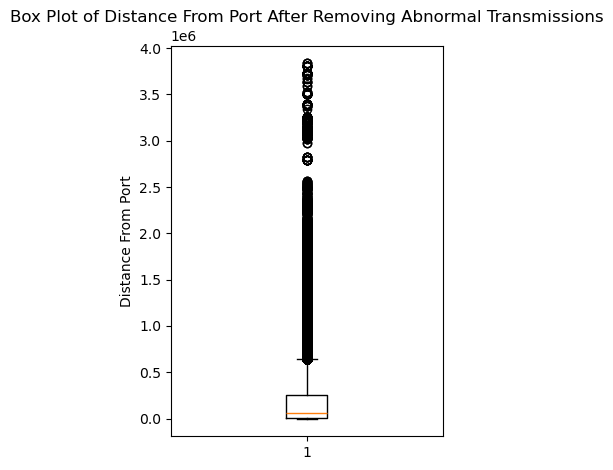

In [691]:

plt.subplot(1, 2, 2)
plt.boxplot(df_geo['distance_from_port'])
plt.title('Box Plot of Distance From Port After Removing Abnormal Transmissions')
plt.ylabel('Distance From Port')

plt.tight_layout()
plt.show()

In [692]:
print(f"Mean Distance From Port AFTER Removing Port Transmissions: {df_geo['distance_from_port'].mean()}")
print(f"Variance, Distance From Port AFTER Removing Port Transmissions: {df_geo['distance_from_port'].var()}")

Mean Distance From Port AFTER Removing Port Transmissions: 280528.271313442
Variance, Distance From Port AFTER Removing Port Transmissions: 231184844776.8549


Sometimes these transmitters send outlandish data.  It's worth looking at the max speed of trawlers and examine the time between transmissions and the distance from port it describles

In [694]:
# Calculate mean and variance of distance_from_port before cleaning
mean_before = df_geo['distance_from_port'].mean()
variance_before = df_geo['distance_from_port'].var()

print(f"Mean before cleaning: {mean_before}")
print(f"Variance before cleaning: {variance_before}")

Mean before cleaning: 280528.271313442
Variance before cleaning: 231184844776.8549


In [860]:
# Max speed in knots (1 knot = 1.852 km/h, or 0.514444 m/s)
max_transit_speed_knots = 70  # knots; this is max speed a trawler would go when transitting (fishing is closer to 4-6 knots
max_transit_speed_m_per_sec = max_transit_speed_knots * 0.514444  # meters per second

# Sort the data by 'mmsi' and 'timestamp'
df_geo = df_geo.sort_values(by=['mmsi', 'timestamp'])

# Calculate the time difference in seconds between consecutive rows for each mmsi
df_geo['time_diff_seconds'] = df_geo.groupby('mmsi')['timestamp'].diff().dt.total_seconds()

# Calculate the actual distance difference (from 'distance_from_port') between consecutive rows
df_geo['port_distance_diff'] = df_geo.groupby('mmsi')['distance_from_port'].diff().abs()

# Calculate the maximum distance they could have traveled at the max speed in that time
df_geo['max_possible_distance'] = df_geo['time_diff_seconds'] * max_transit_speed_m_per_sec

# Flag rows where the actual distance is greater than the max possible distance (indicating an abnormal jump)
abnormal_jumps = df_geo[df_geo['port_distance_diff'] > df_geo['max_possible_distance']]

# display the rows with the abnormal jumps
abnormal_jumps

index             mmsi           timestamp  distance_from_shore  \
2         61079    1252339803566 2015-01-05 00:05:24              0.00000   
3         61080    1252339803566 2015-01-05 00:17:33              0.00000   
197       61526    1252339803566 2015-01-24 01:17:05              0.00000   
198       61527    1252339803566 2015-01-24 01:32:02              0.00000   
200       61638    1252339803566 2015-01-25 01:53:50              0.00000   
...         ...              ...                 ...                  ...   
170714  3310497  274850145767759 2015-07-17 17:43:05         739322.81250   
170798  3310760  274850145767759 2015-07-20 07:05:35         824611.18750   
171064  3311907  274850145767759 2015-08-01 17:51:20         516022.25000   
171712  3314535  274850145767759 2015-08-28 16:39:43         461522.00000   
172506  3317454  274850145767759 2015-09-29 04:36:33         448801.84375   

        distance_from_port  speed      course        lat        lon  \
2             4.031030e+04    0.0  350.000000  52.458580   0.000657   
3             0.000000e+00    0.0  337.000000  52.458698   4.581316   
197           4.031030e+04    0.0  128.000000  52.462399   0.000537   
198           0.000000e+00    0.0  121.000000  52.462399   4.582183   
200           4.031030e+04    0.0  333.000000  52.462318   0.000752   
...                    ...    ...         ...        ...        ...   
170714        9.521919e+05   10.0  102.500000 -39.053959 -81.925705   
170798        1.012931e+06    7.6  260.200012 -39.559849 -82.517265   
171064        6.198372e+05    3.5  328.200012 -38.272018 -78.601341   
171712        5.840071e+05    5.5  259.399994 -37.065559 -78.415253   
172506        5.113787e+05   11.9  339.799988 -10.141515 -83.155205   

        is_fishing           source  hour                     geometry  \
2              0.0              gfw     0     POINT (0.00066 52.45858)   
3              0.0              gfw     0      POINT (4.58132 52.4587)   
197            0.0              gfw     1      POINT (0.00054 52.4624)   
198            0.0              gfw     1      POINT (4.58218 52.4624)   
200            0.0              gfw     1     POINT (0.00075 52.46232)   
...            ...              ...   ...                          ...   
170714         0.0  dalhousie_trawl    17   POINT (-81.9257 -39.05396)   
170798         0.0  dalhousie_trawl     7  POINT (-82.51727 -39.55985)   
171064         1.0  dalhousie_trawl    17  POINT (-78.60134 -38.27202)   
171712         1.0  dalhousie_trawl    16  POINT (-78.41525 -37.06556)   
172506         0.0  dalhousie_trawl     4   POINT (-83.1552 -10.14151)   

        time_diff_seconds  port_distance_diff  max_possible_distance  
2                   752.0        40310.296875            27080.33216  
3                   729.0        40310.296875            26252.07732  
197                 721.0        40310.296875            25963.98868  
198                 897.0        40310.296875            32301.93876  
200                 726.0        40310.296875            26144.04408  
...                   ...                 ...                    ...  
170714                9.0          992.437500              324.09972  
170798               11.0          999.000000              396.12188  
171064                7.0          368.750000              252.07756  
171712               21.0          999.937500              756.23268  
172506                9.0          421.218750              324.09972  

[1004 rows x 16 columns]

There's 1004 rows where there's abnormal jumps:

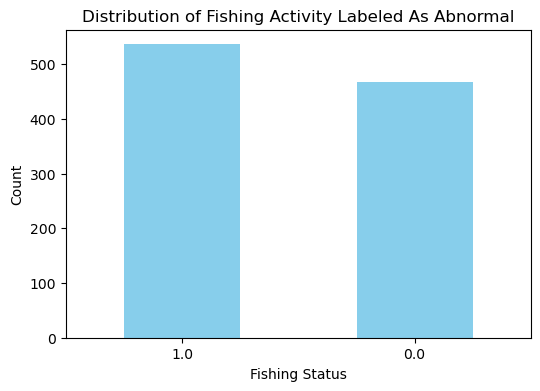

In [697]:
abnormal_jumps_dataloss = abnormal_jumps['is_fishing'].value_counts()

plt.figure(figsize=(6, 4))
abnormal_jumps_dataloss.plot(kind='bar', color='skyblue')
plt.title('Distribution of Fishing Activity Labeled As Abnormal')
plt.xlabel('Fishing Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

This is relatively balanced . . . the dalhouse trawl data set is the largest source, followed by gfw so it doesn't seem like one dataset is noisier than the other . . . 

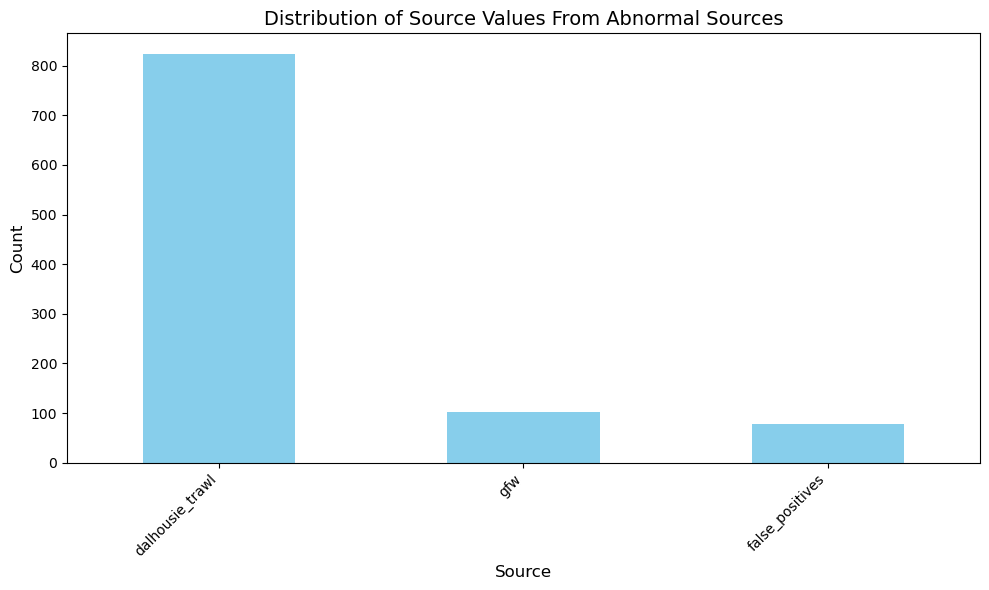

In [699]:
# Count the occurrences of each unique value in the 'source' column
source_counts = abnormal_jumps['source'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
source_counts.plot(kind='bar', color='skyblue')

# Add labels and title
plt.title('Distribution of Source Values From Abnormal Sources', fontsize=14)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

Drop these values from df_geo 

In [862]:
df_geo = df_geo.drop(abnormal_jumps.index)


In [629]:
# Calculate mean and variance of distance_from_port before cleaning
mean_before = df_geo['distance_from_port'].mean()
variance_before = df_geo['distance_from_port'].var()

print(f"Mean After cleaning: {mean_before}")
print(f"Variance After cleaning: {variance_before}")

Mean After cleaning: 277794.87139886105
Variance After cleaning: 229248240315.53775


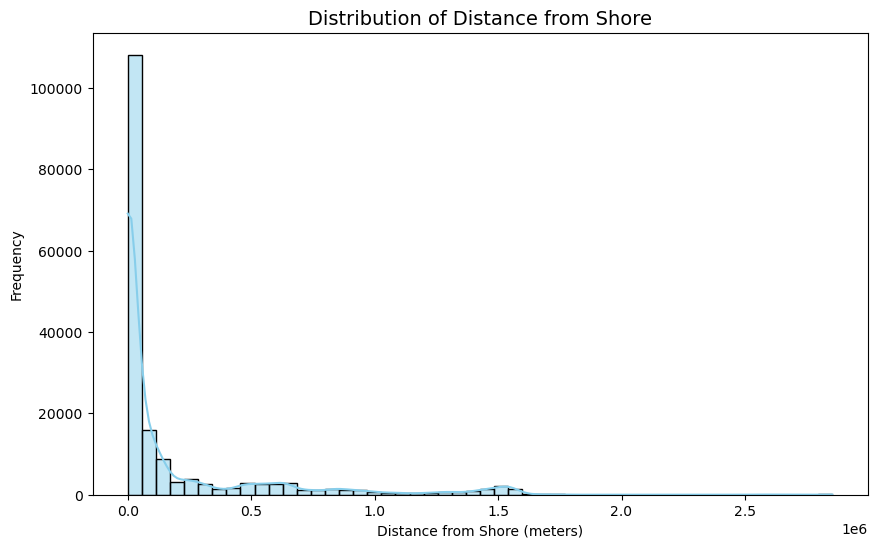

In [630]:
# Histogram of Distance from Shore
plt.figure(figsize=(10, 6))
sns.histplot(df_geo['distance_from_shore'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Distance from Shore', fontsize=14)
plt.xlabel('Distance from Shore (meters)')
plt.ylabel('Frequency')
plt.show()


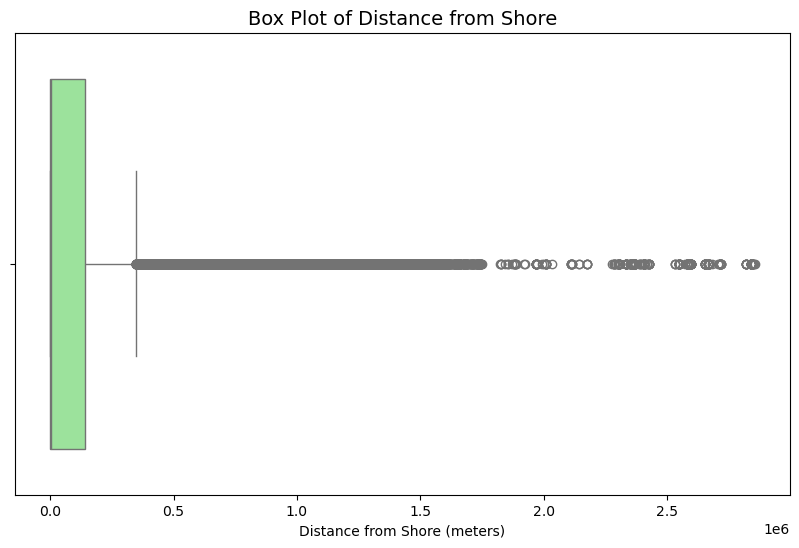

In [631]:
# Boxplot of Distance from Shore
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_geo['distance_from_shore'], color='lightgreen')
plt.title('Box Plot of Distance from Shore', fontsize=14)
plt.xlabel('Distance from Shore (meters)')
plt.show()

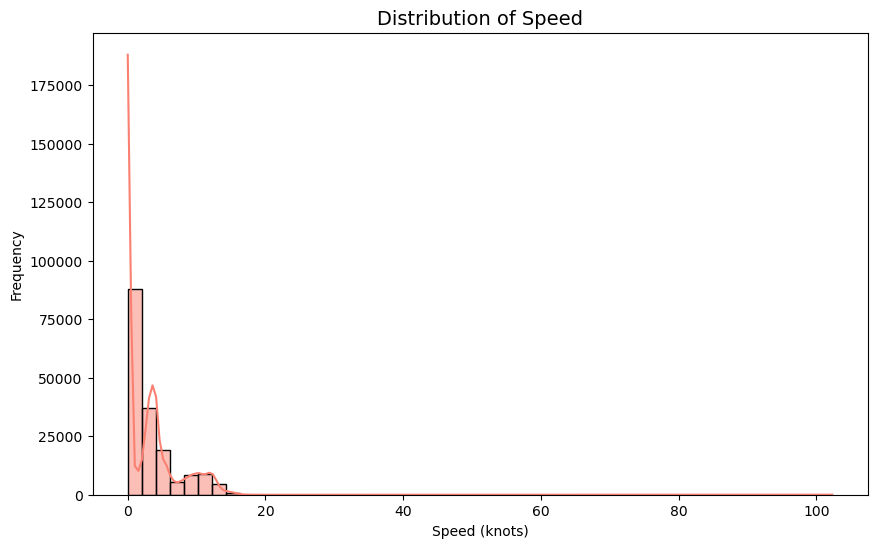

In [632]:
# Histogram of Speed
plt.figure(figsize=(10, 6))
sns.histplot(df_geo['speed'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Speed', fontsize=14)
plt.xlabel('Speed (knots)')
plt.ylabel('Frequency')
plt.show()

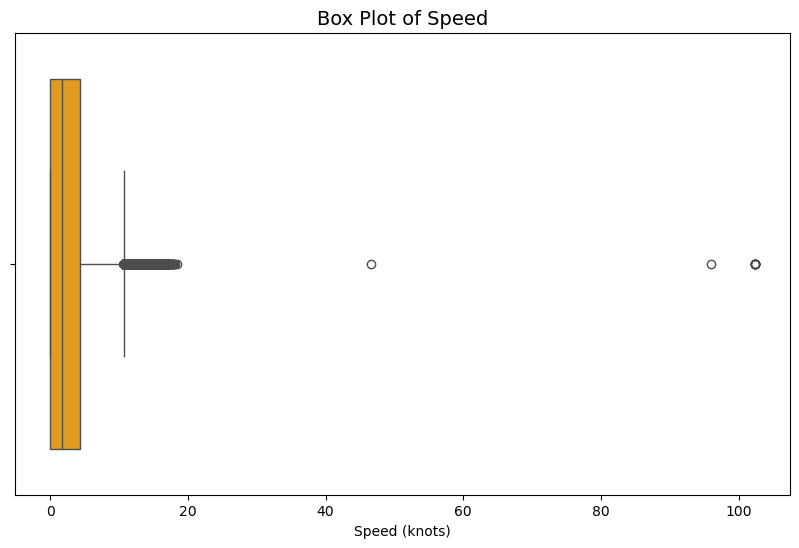

In [633]:
# Reset index to avoid duplicate index values
df_geo = df_geo.reset_index(drop=True)

# Now plot the boxplot again
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_geo['speed'], color='orange')
plt.title('Box Plot of Speed', fontsize=14)
plt.xlabel('Speed (knots)')
plt.show()

In [634]:
# Calculate the mean speed before replacing outliers
mean_speed_before = df_geo['speed'].mean()
variance_speed_before = df_geo['speed'].var()

print(f"Mean speed before replacing outliers: {mean_speed_before}")
print(f"Variance of speed before replacing outliers: {variance_speed_before}")

# Replace speed > 80 with the mean speed
mean_speed = df_geo['speed'].mean()
df_geo.loc[df_geo['speed'] > 80, 'speed'] = mean_speed

# Calculate the mean and variance after replacing outliers
mean_speed_after = df_geo['speed'].mean()
variance_speed_after = df_geo['speed'].var()

print(f"\nMean speed after replacing outliers: {mean_speed_after}")
print(f"Variance of speed after replacing outliers: {variance_speed_after}")


Mean speed before replacing outliers: 2.9950663930756205
Variance of speed before replacing outliers: 14.715084819364131

Mean speed after replacing outliers: 2.98992271207408
Variance of speed after replacing outliers: 14.207658598048289


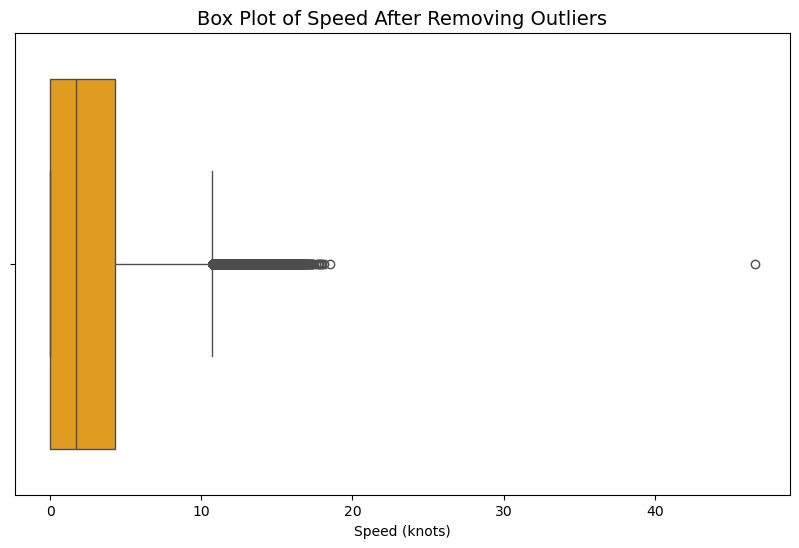

In [635]:
# Reset index to avoid duplicate index values
df_geo = df_geo.reset_index(drop=True)

# Now plot the boxplot again
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_geo['speed'], color='orange')
plt.title('Box Plot of Speed After Removing Outliers', fontsize=14)
plt.xlabel('Speed (knots)')
plt.show()

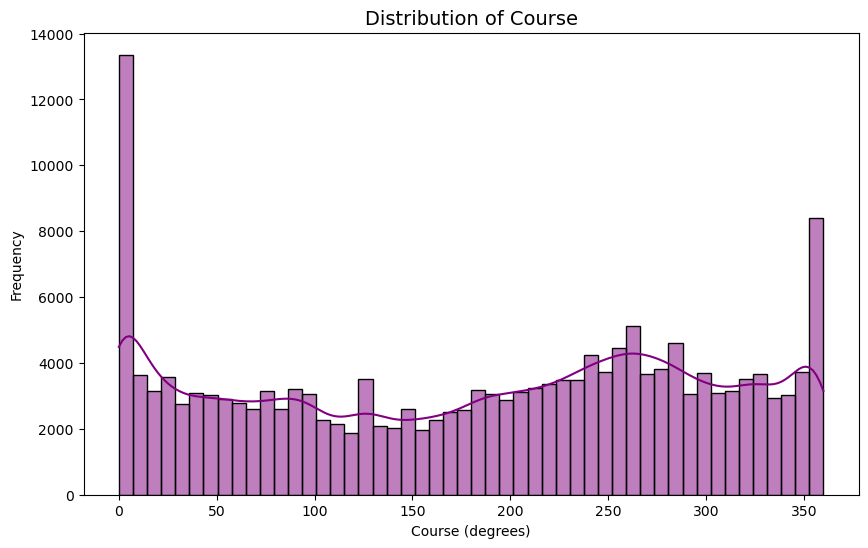

In [636]:
# Histogram of Course
plt.figure(figsize=(10, 6))
sns.histplot(df_geo['course'], bins=50, kde=True, color='purple')
plt.title('Distribution of Course', fontsize=14)
plt.xlabel('Course (degrees)')
plt.ylabel('Frequency')
plt.show()

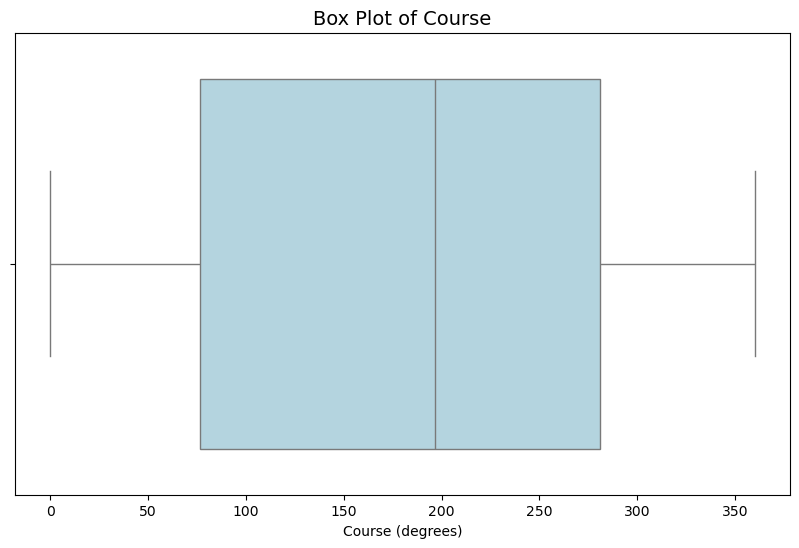

In [637]:
# Boxplot of Course
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['course'], color='lightblue')
plt.title('Box Plot of Course', fontsize=14)
plt.xlabel('Course (degrees)')
plt.show()

Add Lag Variables

In [864]:
# Ensure the data is sorted by 'mmsi' and 'timestamp' to maintain the order of observations for each ship
df_geo = df_geo.sort_values(by=['mmsi', 'timestamp'])

# Create lag features for 'speed', 'course', and 'distance_from_port' grouped by 'mmsi'
df_geo['lag_speed'] = df_geo.groupby('mmsi')['speed'].shift(1)
df_geo['lag_course'] = df_geo.groupby('mmsi')['course'].shift(1)
df_geo['lag_distance_from_port'] = df_geo.groupby('mmsi')['distance_from_port'].shift(1)
df_geo['lag_distance_from_shore'] = df_geo.groupby('mmsi')['distance_from_shore'].shift(1)

# Fill NaN values that result from the shift 
df_geo.fillna(0, inplace=True)


Create a training and test set . . . Ensure data is split evening across labels and future data is not included

In [866]:

# Step 1: Group by 'mmsi' and calculate the proportion of is_fishing for each ship
mmsi_grouped = df_geo.groupby('mmsi')['is_fishing'].mean().reset_index()

# Step 2: Stratify by 'is_fishing' label (average fishing behavior per ship)
# Create a stratification column where ships are classified based on whether they fish or not
stratify_column = mmsi_grouped['is_fishing'].apply(lambda x: 1 if x > 0 else 0)

# Step 3: Split the MMSI into training and test sets while maintaining stratification
train_mmsi, test_mmsi = train_test_split(
    mmsi_grouped['mmsi'], 
    test_size=0.2,  # 20% for test, adjust as needed
    stratify=stratify_column, 
    random_state=42  # Ensure reproducibility
)

# Step 4: Use the train and test mmsi to split the full df_geo
train_set = df_geo[df_geo['mmsi'].isin(train_mmsi)]
test_set = df_geo[df_geo['mmsi'].isin(test_mmsi)]

# Check the distribution of the training and test set
train_is_fishing_dist = train_set['is_fishing'].value_counts(normalize=True)
test_is_fishing_dist = test_set['is_fishing'].value_counts(normalize=True)

# Print the distributions to verify that the split worked as intended
print(f"Training set 'is_fishing' distribution:\n{train_is_fishing_dist}")
print(f"Test set 'is_fishing' distribution:\n{test_is_fishing_dist}")

# Print the size of the training and test sets
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Training set 'is_fishing' distribution:
is_fishing
0.0    0.636886
1.0    0.363114
Name: proportion, dtype: float64
Test set 'is_fishing' distribution:
is_fishing
0.0    0.587782
1.0    0.412218
Name: proportion, dtype: float64
Training set size: 149584
Test set size: 22949


Plot Train Set:

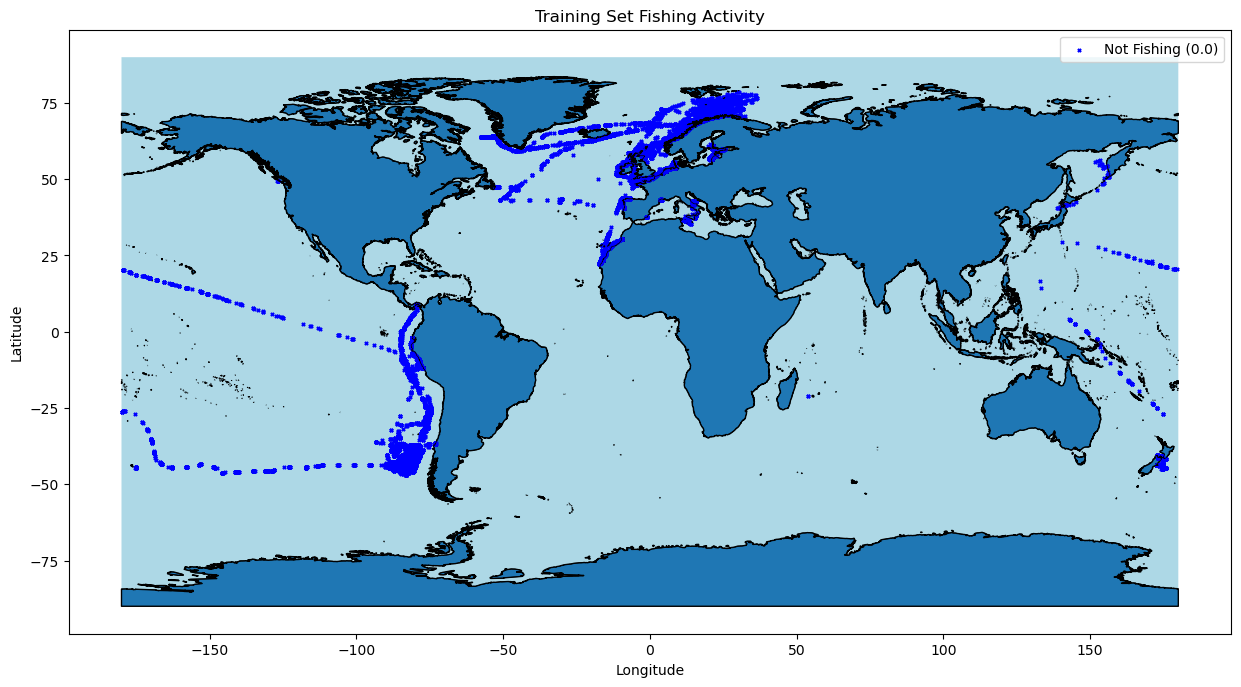

In [559]:
# Plot each layer
fig, ax = plt.subplots(figsize=(15, 10))

# Plot ocean first 
ocean.plot(ax=ax, color='lightblue')

# Plot land
land.plot(ax=ax, edgecolor='black')

# Plot minor islands
minor_islands.plot(ax=ax, color='green', edgecolor='black')

# Plot coastlines on top
coastlines.plot(ax=ax, color='black', linewidth=0.5)

# Overlay the fishing data with different colors/markers for fishing and non-fishing points
# Points where is_fishing == 1.0 (fishing)
train_set[train_set['is_fishing'] == 1.0].plot(
    ax=ax, marker='o', color='red', markersize=5, label='Fishing (1.0)', linestyle='None'
)
# Points where is_fishing == 0.0 (not fishing)
train_set[train_set['is_fishing'] == 0.0].plot(
    ax=ax, marker='x', color='blue', markersize=5, label='Not Fishing (0.0)', linestyle='None'
)

# Add labels and title
plt.title('Training Set Fishing Activity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend to differentiate between fishing and not fishing
plt.legend()

# Show the plot
plt.show()

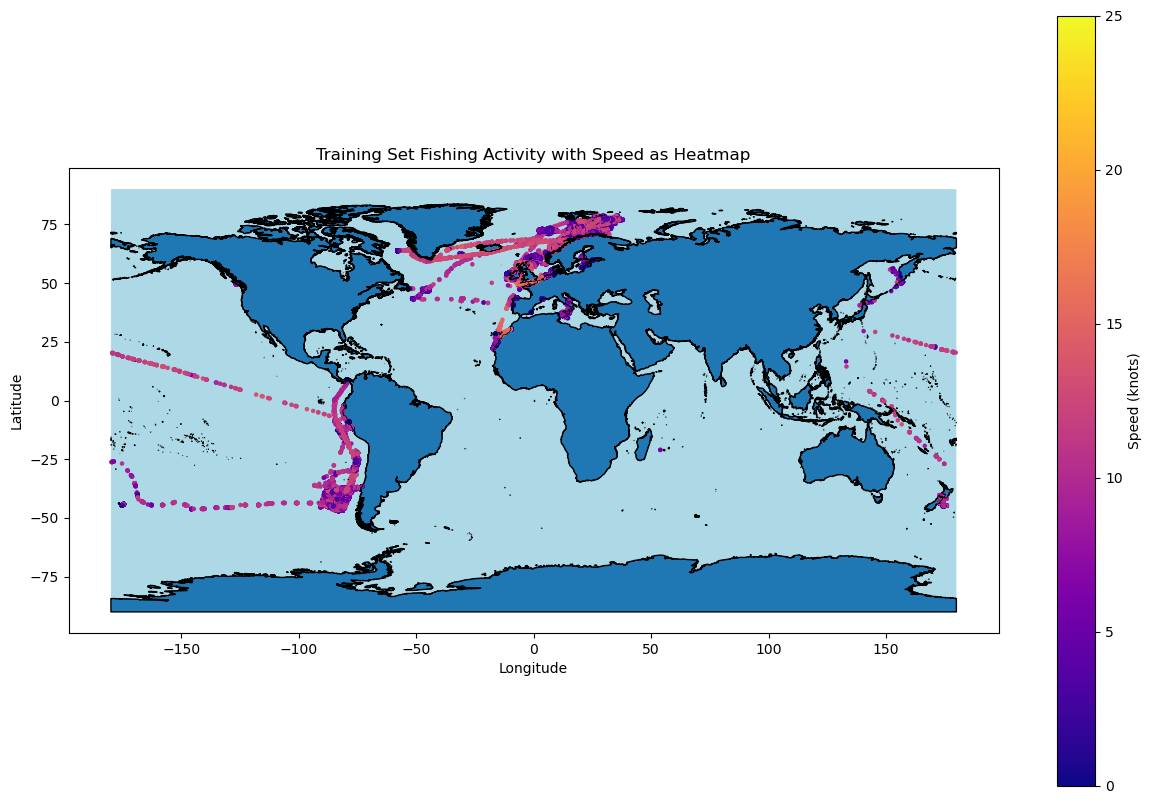

In [590]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

speed_cap = 25

train_set_clipped = train_set.copy()
train_set_clipped['speed'] = train_set_clipped['speed'].clip(upper=speed_cap)

# Normalize the capped speed values for the colormap
norm = plt.Normalize(vmin=train_set_clipped['speed'].min(), vmax=train_set_clipped['speed'].max())
cmap = plt.cm.plasma  

# Plot each layer
fig, ax = plt.subplots(figsize=(15, 10))

# Plot ocean first
ocean.plot(ax=ax, color='lightblue')

# Plot land
land.plot(ax=ax, edgecolor='black')

# Plot minor islands
minor_islands.plot(ax=ax, color='green', edgecolor='black')

# Plot coastlines on top
coastlines.plot(ax=ax, color='black', linewidth=0.5)

# Plot data points using a colormap for speed
sc = ax.scatter(
    train_set_clipped['lon'], 
    train_set_clipped['lat'],  
    c=train_set_clipped['speed'], 
    cmap=cmap, 
    s=5, 
    marker='o', 
    norm=norm, 
    label='Speed (knots)'
)

# Add a colorbar to show the speed scale
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Speed (knots)')

# Add labels and title
plt.title('Training Set Fishing Activity with Speed as Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

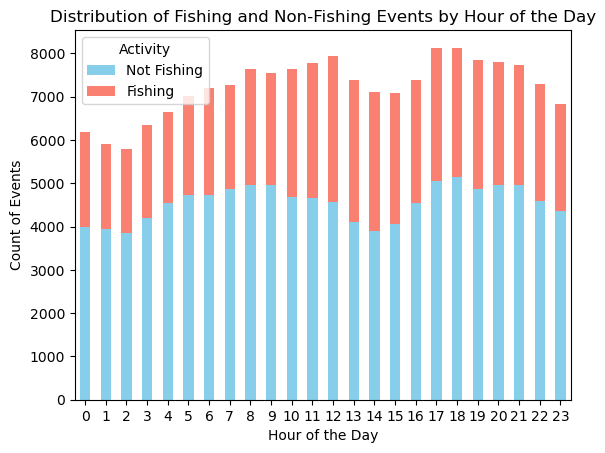

In [592]:

# Extract the hour from the timestamp
df_geo['hour'] = df_geo['timestamp'].dt.hour

# Create a pivot table to break out fishing vs. non-fishing by hour
hourly_fishing_activity = df_geo.pivot_table(index='hour', columns='is_fishing', aggfunc='size', fill_value=0)

# Plot a stacked bar chart to differentiate between fishing and non-fishing activity
plt.figure(figsize=(12, 6))
hourly_fishing_activity.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])

# Add titles and labels
plt.title('Distribution of Fishing and Non-Fishing Events by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Events')
plt.legend(['Not Fishing', 'Fishing'], title='Activity')

# Display the plot
plt.xticks(rotation=0)
plt.show()

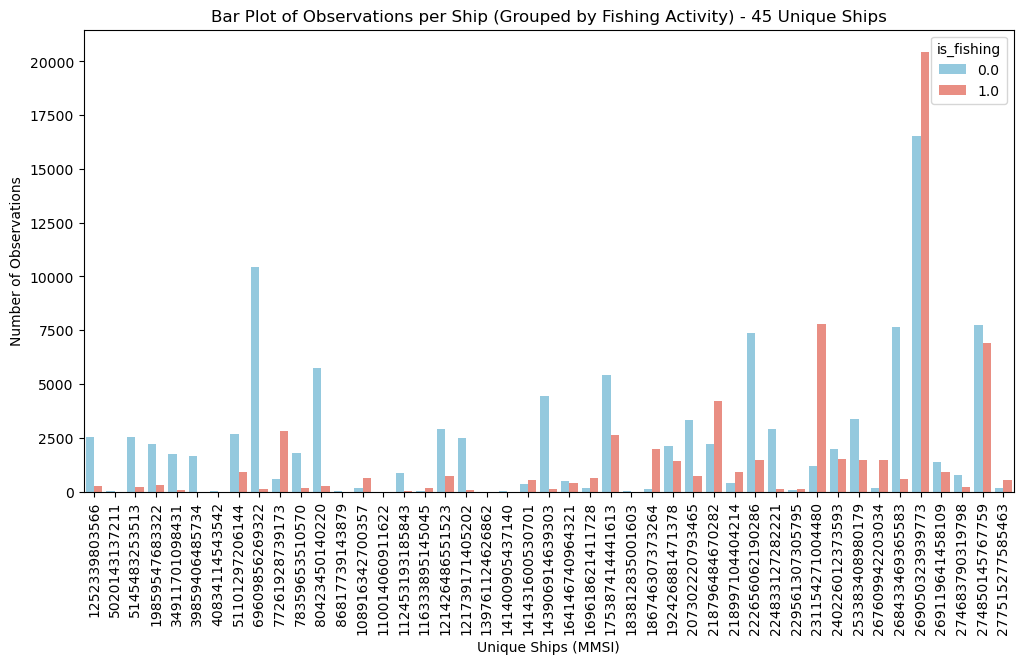

In [868]:
unique_mmsi_count = df_geo['mmsi'].nunique()

# Bar plot of observations for each ship, broken out by fishing activity
plt.figure(figsize=(12, 6))

# Group by 'mmsi' and 'is_fishing', and count the number of observations for each group
df_mmsi_fishing_count = df_geo.groupby(['mmsi', 'is_fishing']).size().reset_index(name='observations')

# Create the bar plot with a split by fishing activity
sns.barplot(x='mmsi', y='observations', hue='is_fishing', data=df_mmsi_fishing_count, palette=['skyblue', 'salmon'])

# Add titles and labels
plt.title(f'Bar Plot of Observations per Ship (Grouped by Fishing Activity) - {unique_mmsi_count} Unique Ships')
plt.xlabel('Unique Ships (MMSI)')
plt.ylabel('Number of Observations')

# Rotate x-axis labels 90 degrees
plt.xticks(rotation=90)

plt.show()

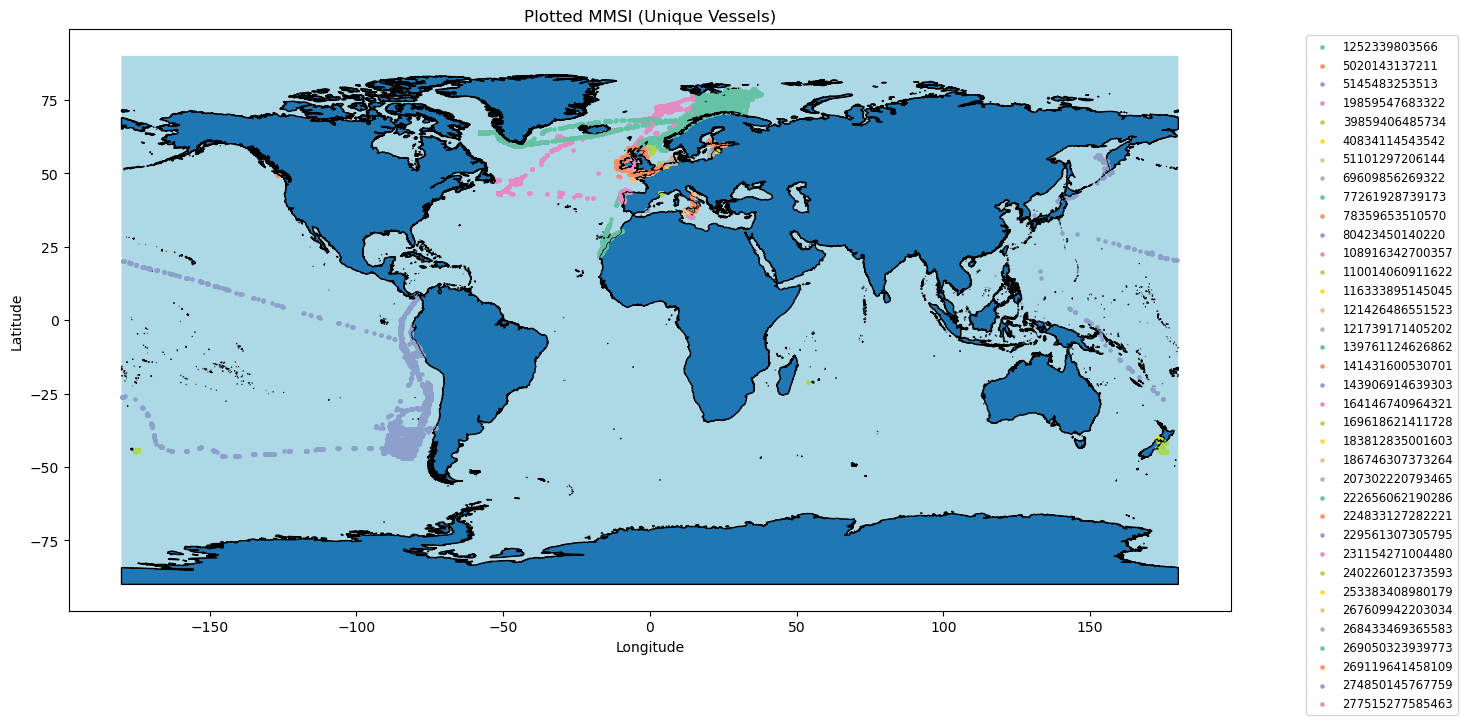

In [876]:


# Generate a unique color for each MMSI with a softer color palette
unique_mmsi = train_set['mmsi'].unique()
num_mmsi = len(unique_mmsi)

# Generate color palette
palette = sns.color_palette("Set2", num_mmsi)

# Create a dictionary to map each MMSI to a specific color
mmsi_color_map = dict(zip(unique_mmsi, palette))

# Plot each layer
fig, ax = plt.subplots(figsize=(15, 10))

# Plot ocean first
ocean.plot(ax=ax, color='lightblue')

# Plot land
land.plot(ax=ax, edgecolor='black')

# Plot minor islands
minor_islands.plot(ax=ax, color='green', edgecolor='black')

# Plot coastlines on top
coastlines.plot(ax=ax, color='black', linewidth=0.5)

# Plot data points with unique colors for each MMSI
for mmsi, color in mmsi_color_map.items():
    vessel_data = train_set[train_set['mmsi'] == mmsi]  # Include all transmissions (fishing and non-fishing)
    ax.scatter(vessel_data['lon'], vessel_data['lat'], color=color, label=str(mmsi), s=5, marker='o')


# Add labels and title
plt.title('Plotted MMSI (Unique Vessels)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend to differentiate between MMSI 
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')

# Show the plot
plt.show()

DBSCAN can be useful in detecting prominate fishing areas (transient areas will likely be left unclustered)

In [40]:

# Identify which fields in df_geo contain NaN values
nan_fields = train_set.isnull().sum()

# Filter to show only fields with NaN values
nan_fields_with_nans = nan_fields[nan_fields > 0]

# Display the result
print(nan_fields_with_nans)

Series([], dtype: int64)


In [42]:
#drop rows with speed/course are na
train_set = train_set.dropna(subset=['speed', 'course'])

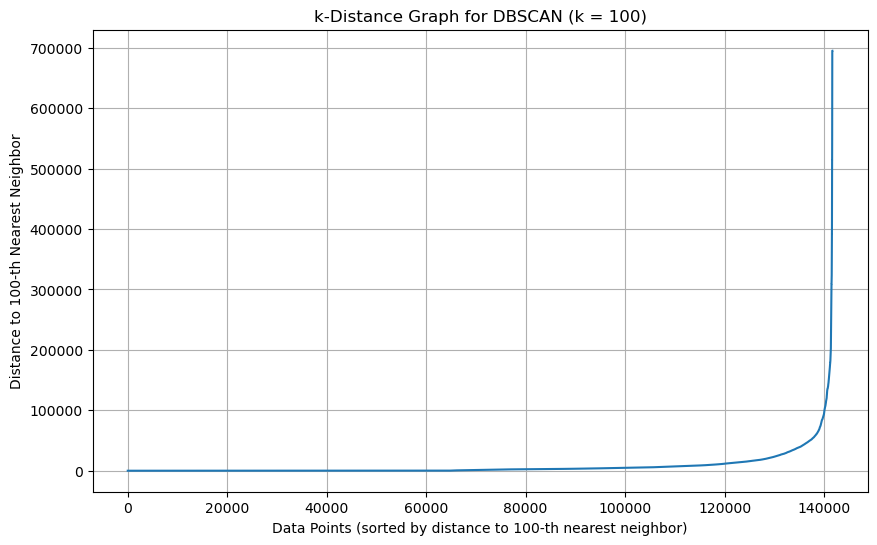

In [44]:
from sklearn.neighbors import NearestNeighbors

# Choose the number of neighbors (min_samples in DBSCAN)
min_samples = 100

# Select the features for DBSCAN (same as in your previous clustering step)
X = train_set[['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore']].values

# Fit NearestNeighbors to find the nearest points
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort the distances to the k-th nearest neighbor in descending order
distances = np.sort(distances[:, min_samples - 1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted by distance to {}-th nearest neighbor)'.format(min_samples))
plt.ylabel('Distance to {}-th Nearest Neighbor'.format(min_samples))
plt.title('k-Distance Graph for DBSCAN (k = {})'.format(min_samples))
plt.grid(True)
plt.show()

/var/folders/y4/wdyk690n2635drk5nk9h8scm0000gn/T/ipykernel_81831/3487058643.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_clusters))  # Generate a colormap with len(unique_clusters) colors


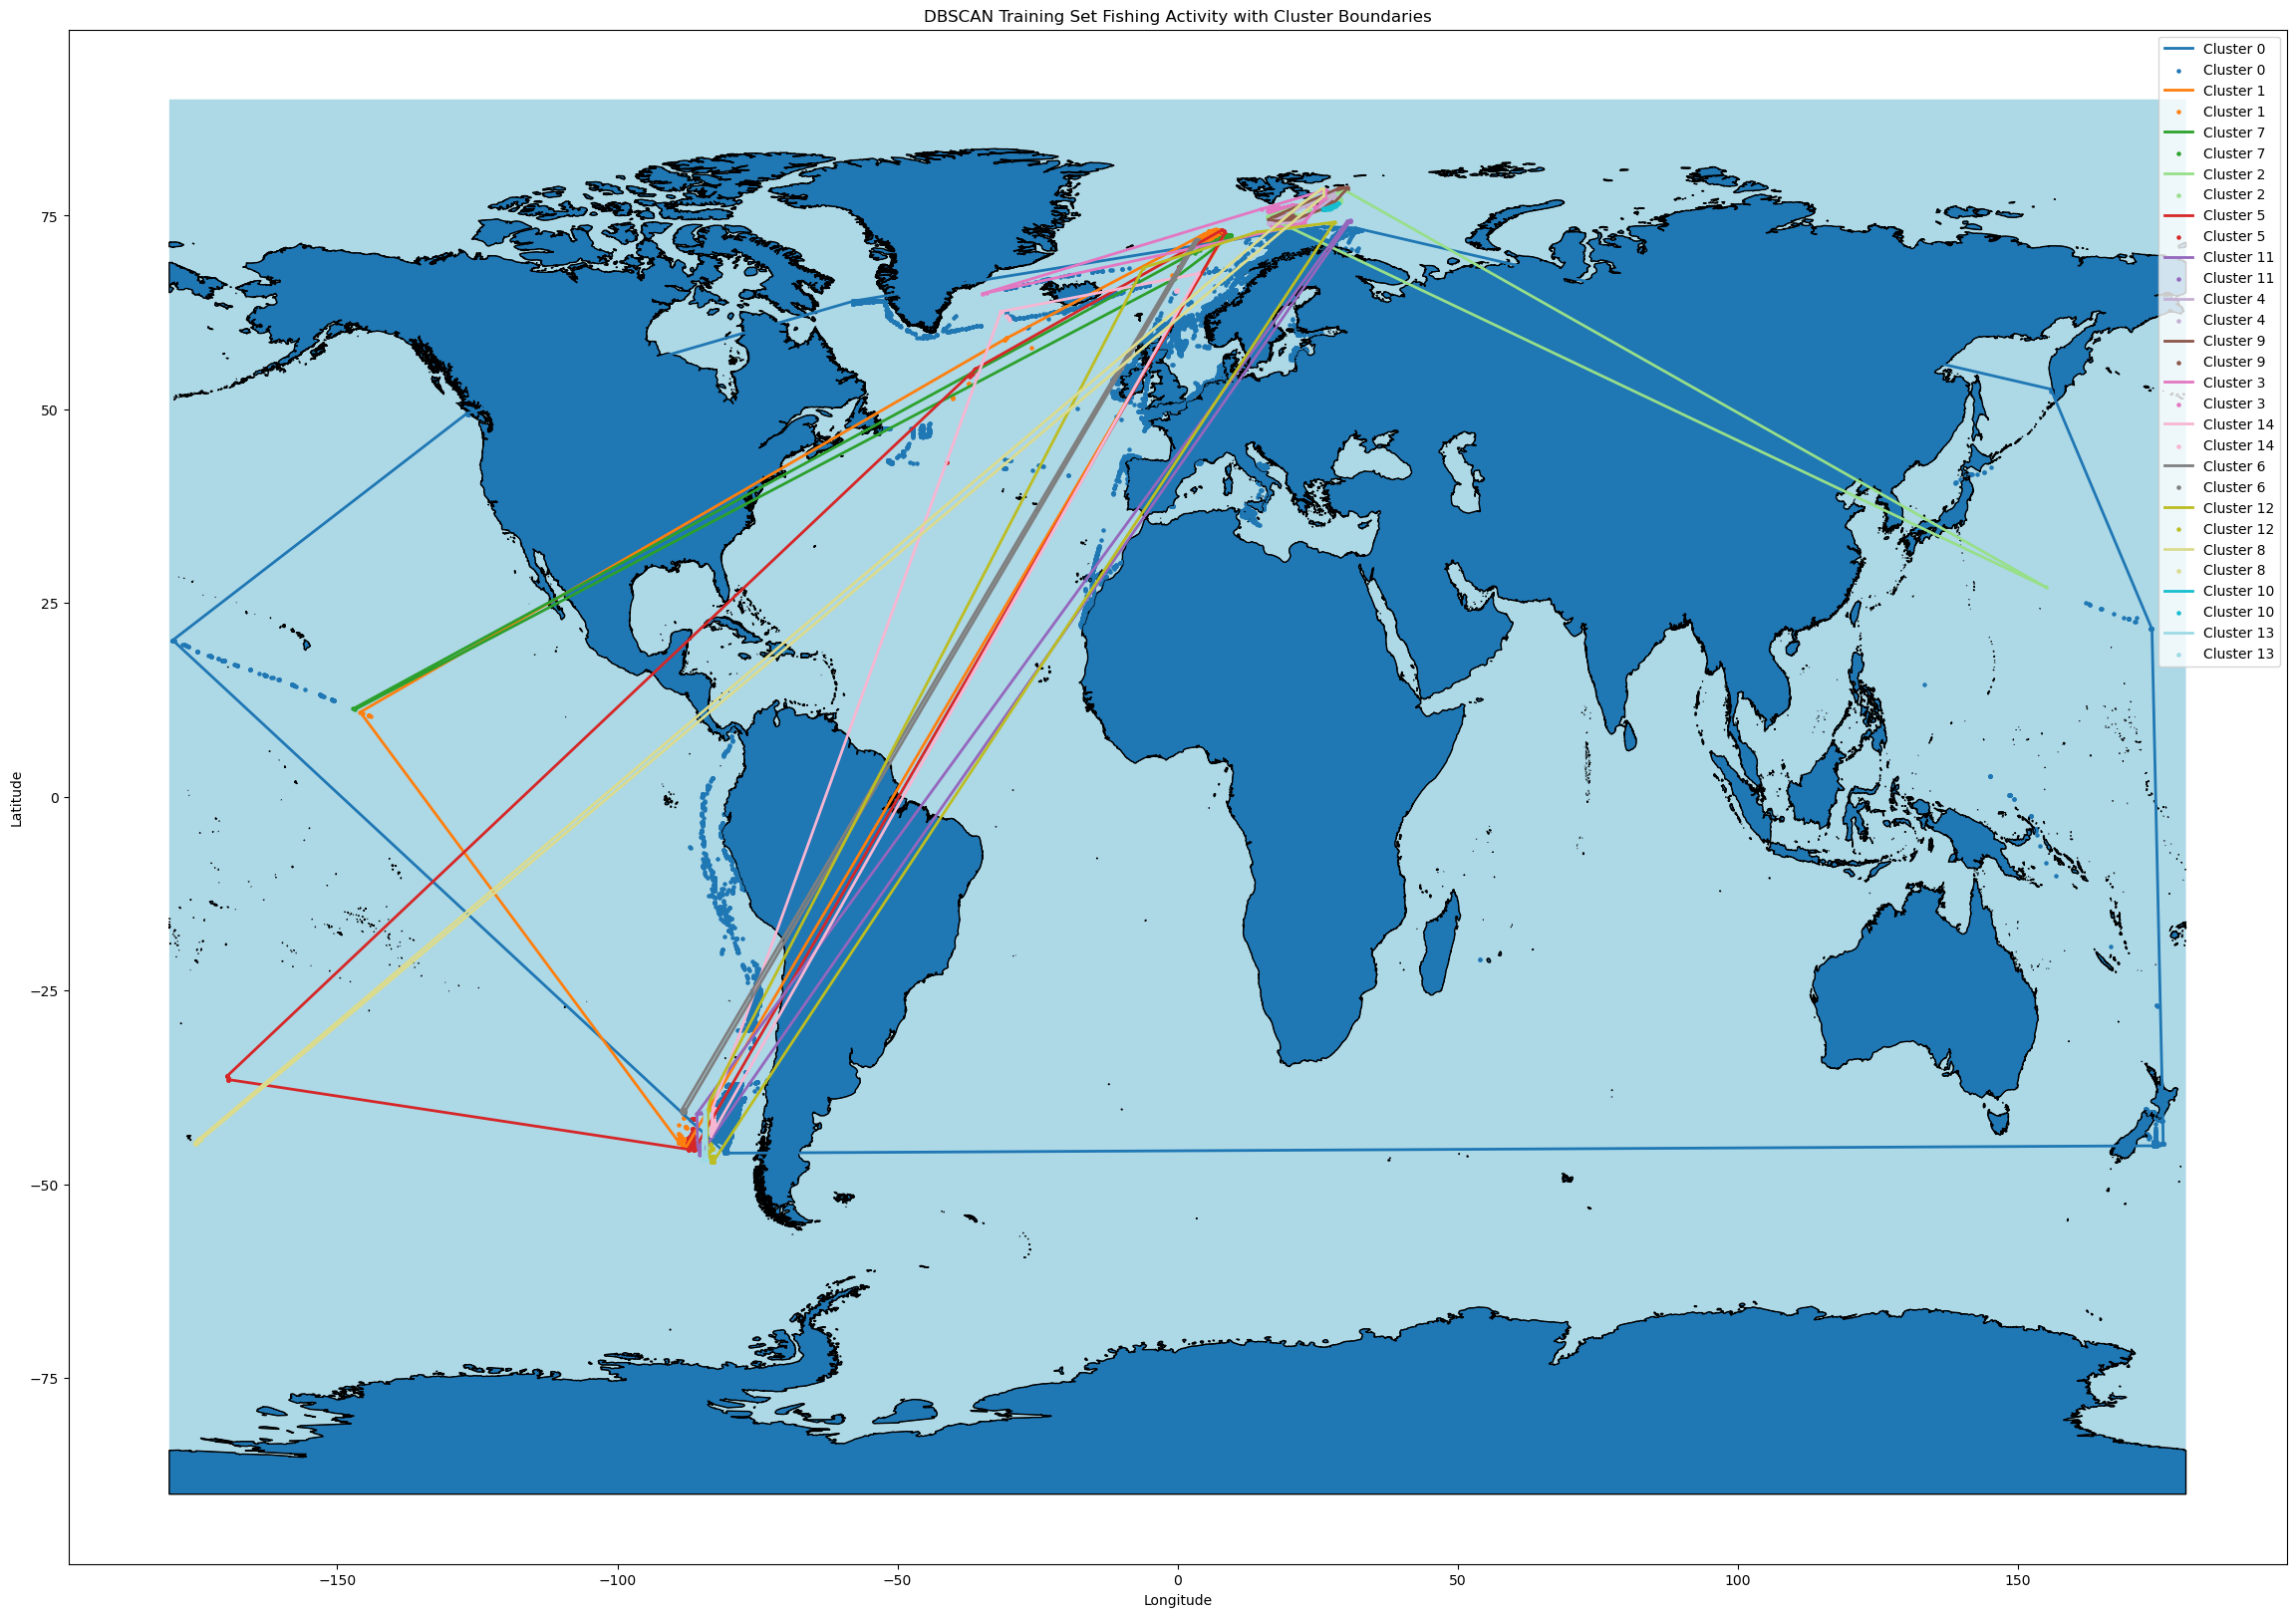

In [49]:
from scipy.spatial import ConvexHull
# Use latitude, longitude, and speed for clustering
X = train_set[['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore']].values

# Apply DBSCAN (you may need to tune eps and min_samples based on your data)
dbscan = DBSCAN(eps=35000.0, min_samples=100)
train_set['cluster'] = dbscan.fit_predict(X)

import matplotlib.cm as cm

# Function to plot convex hull with different colors
def plot_convex_hull(points, ax, color, label):
    hull = ConvexHull(points)
    hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the hull
    ax.plot(points[hull_points, 0], points[hull_points, 1], color=color, linewidth=2, label=label)

# Convert the DataFrame to a GeoDataFrame using the latitude and longitude for geometry
train_set_gdf = gpd.GeoDataFrame(train_set, 
                                 geometry=gpd.points_from_xy(train_set['lon'], train_set['lat']),
                                 crs="EPSG:4326")  # WGS84 coordinate system

# Plot each layer
fig, ax = plt.subplots(figsize=(30, 20))

# Plot ocean first 
ocean.plot(ax=ax, color='lightblue')

# Plot land
land.plot(ax=ax, edgecolor='black')

# Plot minor islands
minor_islands.plot(ax=ax, color='green', edgecolor='black')

# Plot coastlines on top
coastlines.plot(ax=ax, color='black', linewidth=0.5)

# Plot convex hulls and points for each cluster (except noise, cluster -1)
unique_clusters = train_set['cluster'].unique()

# Generate a colormap for unique clusters
cmap = cm.get_cmap('tab20', len(unique_clusters))  # Generate a colormap with len(unique_clusters) colors

for idx, cluster in enumerate(unique_clusters):
    if cluster != -1:  # Skip the noise cluster (-1)
        cluster_points = train_set_gdf[train_set['cluster'] == cluster][['lon', 'lat']].values
        if len(cluster_points) > 2:  # ConvexHull needs at least 3 points
            # Plot convex hull for the cluster
            plot_convex_hull(cluster_points, ax, color=cmap(idx), label=f'Cluster {cluster}')
            # Optionally, plot the cluster points inside the convex hull
            train_set_gdf[train_set['cluster'] == cluster].plot(
                ax=ax, marker='o', color=cmap(idx), markersize=5, label=f'Cluster {cluster}', linestyle='None'
            )

# Add labels and title
plt.title('DBSCAN Training Set Fishing Activity with Cluster Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend to differentiate between clusters
plt.legend()

# Show the plot
plt.show()



In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the data for DBSCAN and t-SNE
X = train_set[['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply DBSCAN (same as before)
dbscan = DBSCAN(eps=0.01, min_samples=100)
train_set['cluster'] = dbscan.fit_predict(X_scaled)

# Step 3: Apply t-SNE to reduce the dimensions of X to 2D for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Step 4: Create a DataFrame with t-SNE results and cluster labels
df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['cluster'] = train_set['cluster']

# Step 5: Use Plotly to create an interactive scatter plot
fig = px.scatter(df_tsne, x='tsne_1', y='tsne_2', color='cluster',
                 title='DBSCAN Clustering Visualized with t-SNE',
                 labels={'cluster': 'Cluster'},
                 hover_data=['cluster'])

# Show the plot
fig.show()

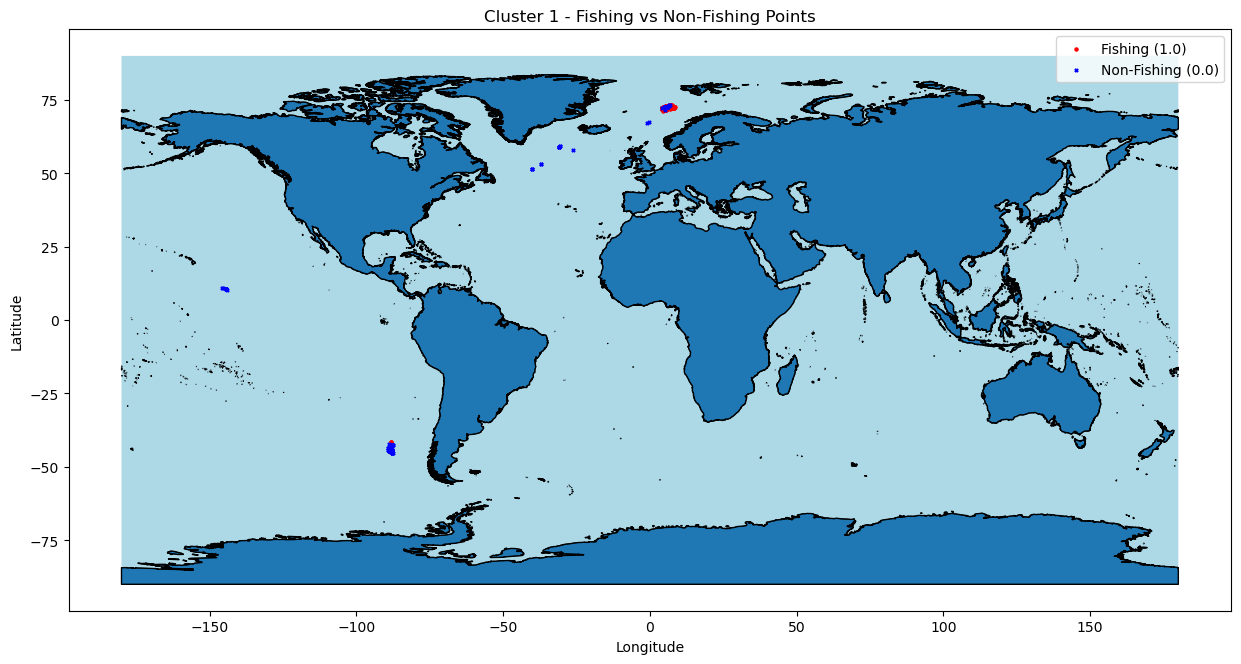

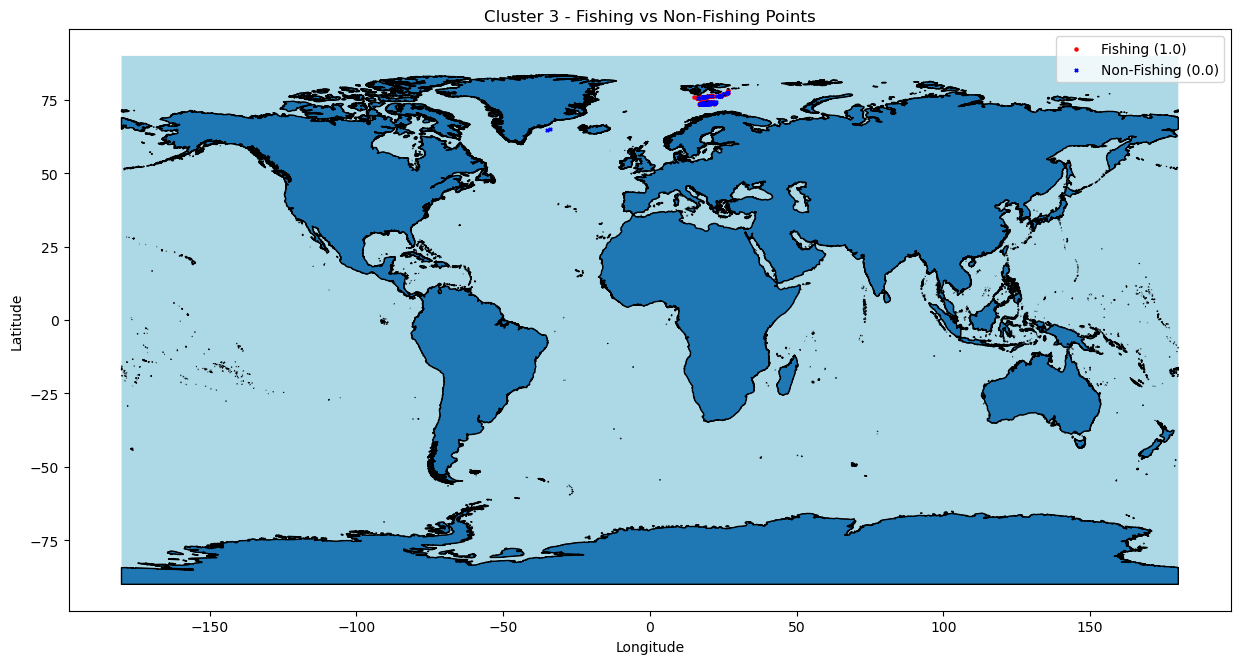

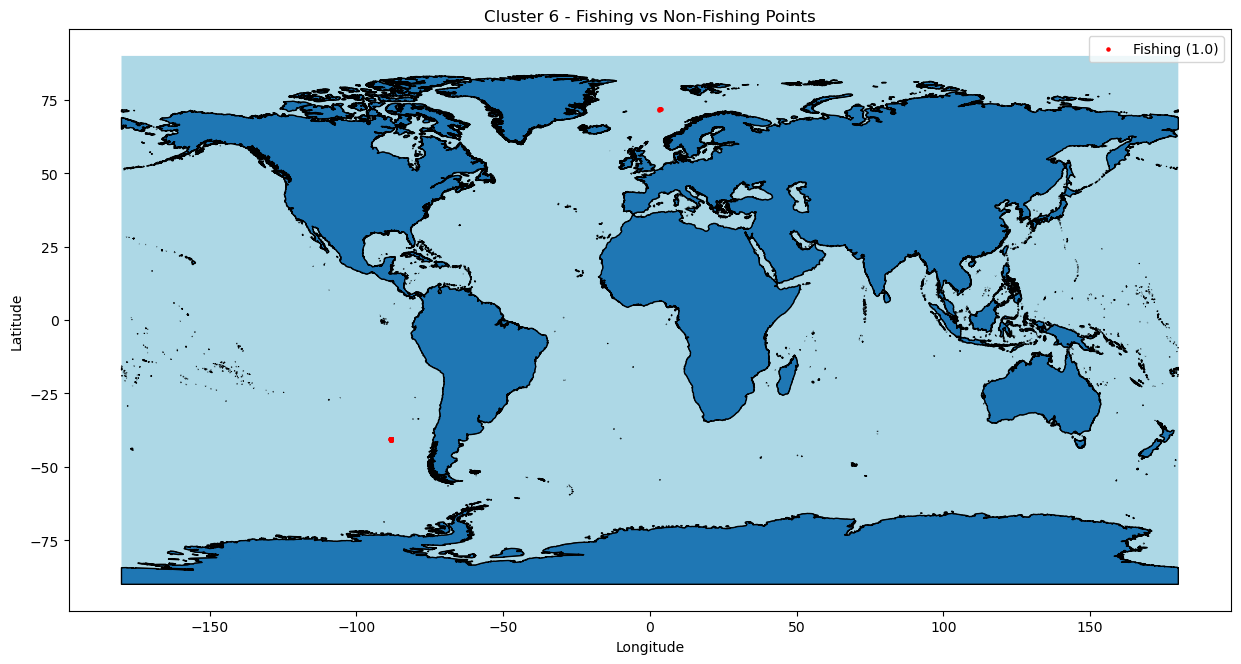

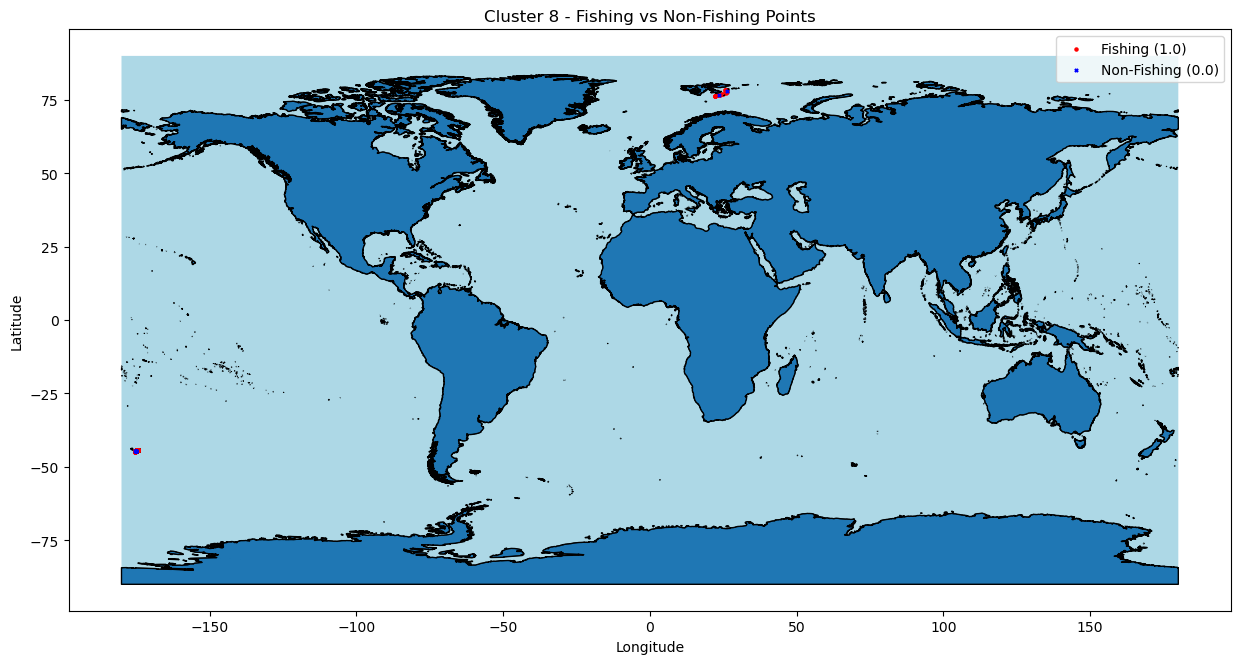

In [117]:
# Plot each cluster in a separate map
for cluster in unique_clusters:

    cluster_gdf = train_set_gdf[train_set_gdf['cluster'] == cluster]
    
    # Check if the GeoDataFrame is empty
    if cluster_gdf.empty:
        print(f"Cluster {cluster} has no valid geometries. Skipping plot.")
        continue
        
    # Create a new plot for each cluster
    fig, ax = plt.subplots(figsize=(15, 10))
        
    # Plot ocean and land (optional layers)
    ocean.plot(ax=ax, color='lightblue')
    land.plot(ax=ax, edgecolor='black')
    minor_islands.plot(ax=ax, color='green', edgecolor='black')
    coastlines.plot(ax=ax, color='black', linewidth=0.5)
        
    # Plot is_fishing == 1 in red, if there are any
    if not cluster_gdf[cluster_gdf['is_fishing'] == 1].empty:
        cluster_gdf[cluster_gdf['is_fishing'] == 1].plot(ax=ax, marker='o', color='red', markersize=5, label='Fishing (1.0)', linestyle='None')
        
    # Plot is_fishing == 0 in blue, if there are any
    if not cluster_gdf[cluster_gdf['is_fishing'] == 0].empty:
        cluster_gdf[cluster_gdf['is_fishing'] == 0].plot(ax=ax, marker='x', color='blue', markersize=5, label='Non-Fishing (0.0)', linestyle='None')
    
    # Force equal aspect ratio
    ax.set_aspect('equal', 'box')
    
    # Set title and labels
    plt.title(f'Cluster {cluster} - Fishing vs Non-Fishing Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
        
    # Add a legend
    plt.legend()
        
    # Show the plot
    plt.show()




In [55]:

# Group by cluster and calculate necessary metrics including avg speed, course, and distance_from_port
cluster_summary = train_set.groupby('cluster').agg(
    total_obs=('is_fishing', 'size'),                 # Total number of observations in the cluster
    total_fishing=('is_fishing', 'sum'),              # Total number of is_fishing == 1
    avg_speed=('speed', 'mean'),                      # Average speed for each cluster
    avg_course=('course', 'mean'),                    # Average course for each cluster
    avg_distance_from_port=('distance_from_port', 'mean'),  # Average distance from port for each cluster
    avg_distance_from_shore =('distance_from_shore','mean')
).reset_index()

# Calculate the percentage of is_fishing within each cluster
cluster_summary['fishing_percentage_in_cluster'] = (cluster_summary['total_fishing'] / cluster_summary['total_obs']) * 100

# Calculate the overall percentage of is_fishing in the cluster out of all is_fishing
total_fishing_obs = train_set['is_fishing'].sum()
cluster_summary['overall_fishing_percentage'] = (cluster_summary['total_fishing'] / total_fishing_obs) * 100

# Display the result
print(cluster_summary)

    cluster  total_obs  total_fishing  avg_speed  avg_course  \
0        -1       4983         2669.0   6.930724  164.387317   
1         0     125416        39801.0   2.703956  183.525022   
2         1       3645         3445.0   3.465652  162.909849   
3         2        454          400.0   3.940308  186.473568   
4         3       3348         3092.0   4.037336  164.385484   
5         4        208          138.0   4.371154  193.008654   
6         5        418          121.0   8.048325  210.089713   
7         6        134          134.0   4.791791  183.377611   
8         7        118          108.0   3.708475  183.282203   
9         8        725          688.0   5.214069  174.791724   
10        9        869          609.0   5.143959  202.290104   
11       10        111           89.0   4.791892  158.640541   
12       11        334          242.0   6.822455  213.550300   
13       12        430          129.0   7.233023  199.624186   
14       13        329          261.0   

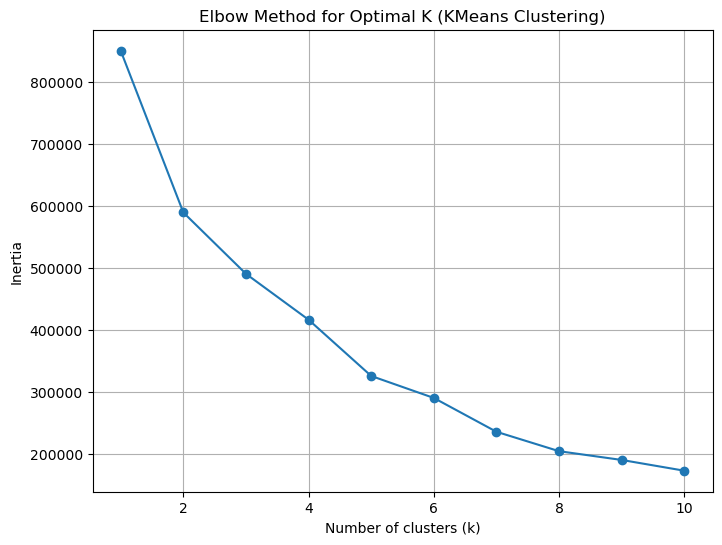

In [75]:
from sklearn.preprocessing import StandardScaler

# Standardize the data to give equal weight to all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method to find the optimal number of clusters
inertia = []
k_values = range(1, 11)  # Try k from 1 to 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K (KMeans Clustering)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [77]:
# Fit KMeans with the optimal number of clusters (e.g., k=4)
optimal_k = 7  # based on elbow

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
train_set['kmeans_cluster'] = kmeans.fit_predict(X_scaled)


/var/folders/y4/wdyk690n2635drk5nk9h8scm0000gn/T/ipykernel_81831/2615883141.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_kmeans_clusters))  # Generate a colormap with len(unique_clusters) colors


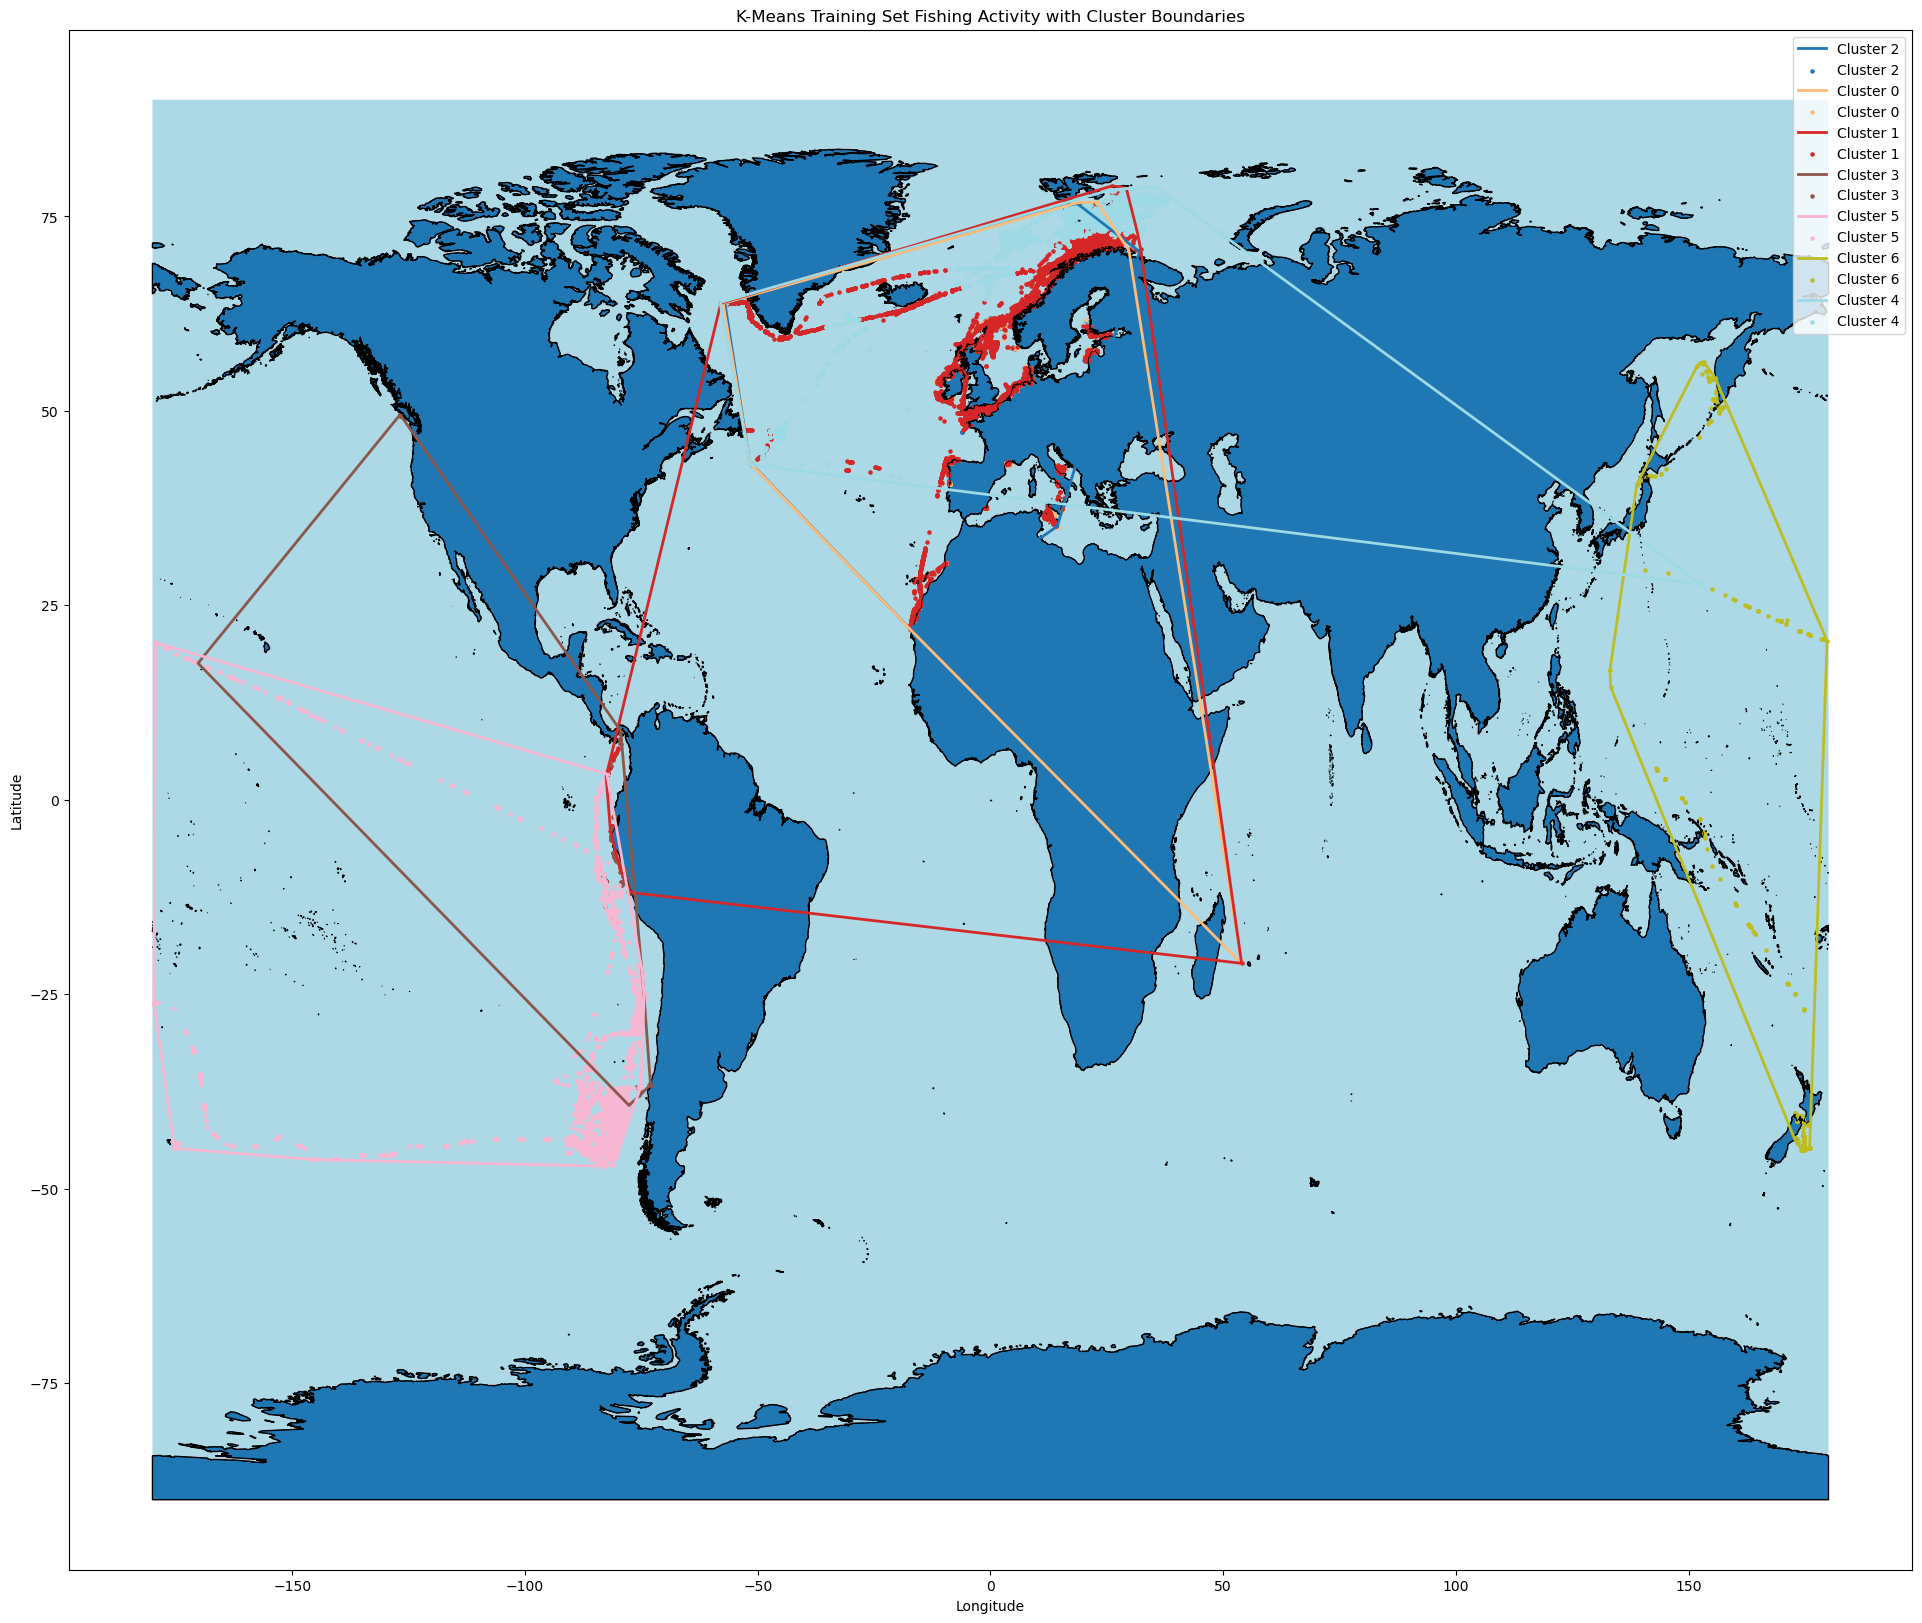

In [79]:

# Function to plot convex hull with different colors
def plot_convex_hull(points, ax, color, label):
    hull = ConvexHull(points)
    hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the hull
    ax.plot(points[hull_points, 0], points[hull_points, 1], color=color, linewidth=2, label=label)

# Convert the DataFrame to a GeoDataFrame using the latitude and longitude for geometry
train_set_gdf = gpd.GeoDataFrame(train_set, 
                                 geometry=gpd.points_from_xy(train_set['lon'], train_set['lat']),
                                 crs="EPSG:4326")  # WGS84 coordinate system

# Plot each layer
fig, ax = plt.subplots(figsize=(30, 20))

# Plot ocean first
ocean.plot(ax=ax, color='lightblue')

# Plot land
land.plot(ax=ax, edgecolor='black')

# Plot minor islands
minor_islands.plot(ax=ax, color='green', edgecolor='black')

# Plot coastlines on top
coastlines.plot(ax=ax, color='black', linewidth=0.5)

# Get the unique k-means clusters
unique_kmeans_clusters = train_set['kmeans_cluster'].unique()

# Generate a colormap for unique clusters
cmap = cm.get_cmap('tab20', len(unique_kmeans_clusters))  # Generate a colormap with len(unique_clusters) colors

# Plot convex hulls and points for each k-means cluster
for idx, cluster in enumerate(unique_kmeans_clusters):
    cluster_points = train_set_gdf[train_set['kmeans_cluster'] == cluster][['lon', 'lat']].values
    if len(cluster_points) > 2:  # ConvexHull needs at least 3 points
        # Plot convex hull for the cluster
        plot_convex_hull(cluster_points, ax, color=cmap(idx), label=f'Cluster {cluster}')
        # Optionally, plot the cluster points inside the convex hull
        train_set_gdf[train_set['kmeans_cluster'] == cluster].plot(
            ax=ax, marker='o', color=cmap(idx), markersize=5, label=f'Cluster {cluster}', linestyle='None'
        )

# Add labels and title
plt.title('K-Means Training Set Fishing Activity with Cluster Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend to differentiate between clusters
plt.legend()

# Show the plot
plt.show()

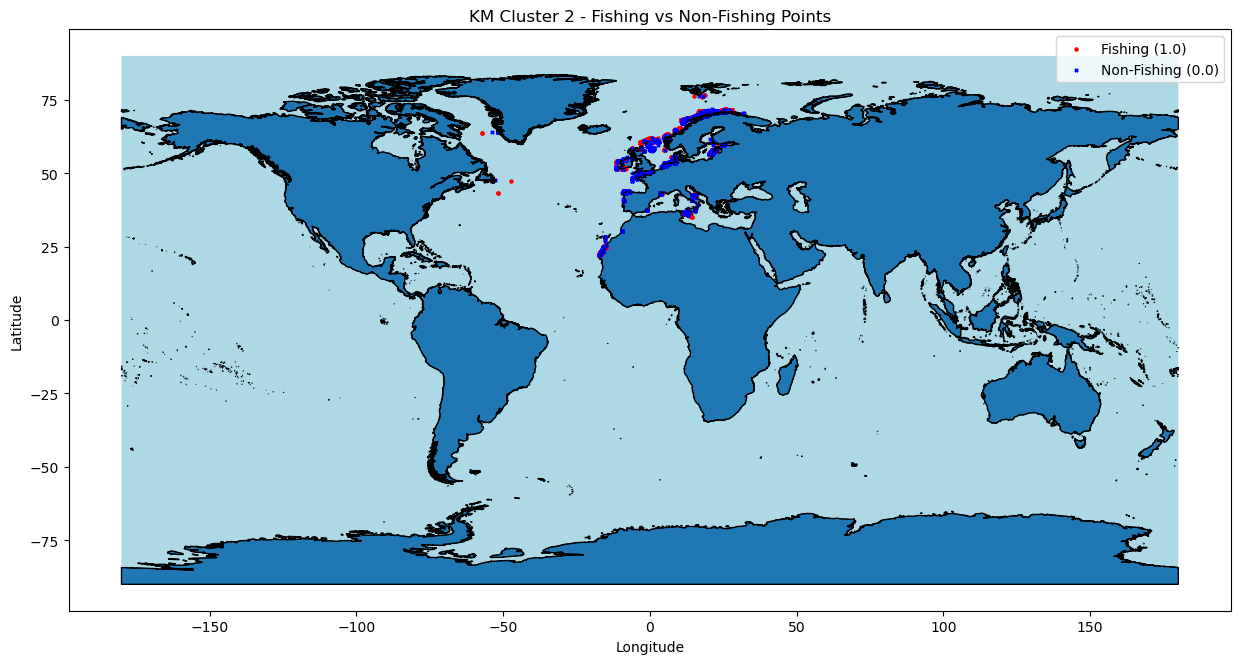

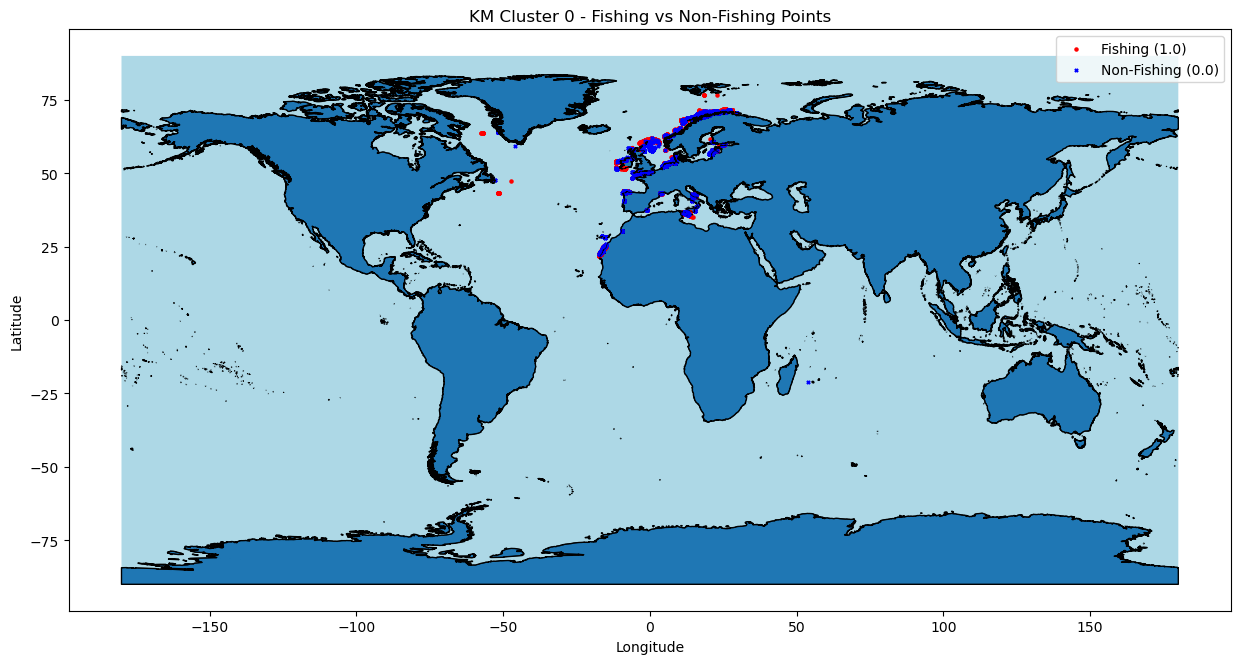

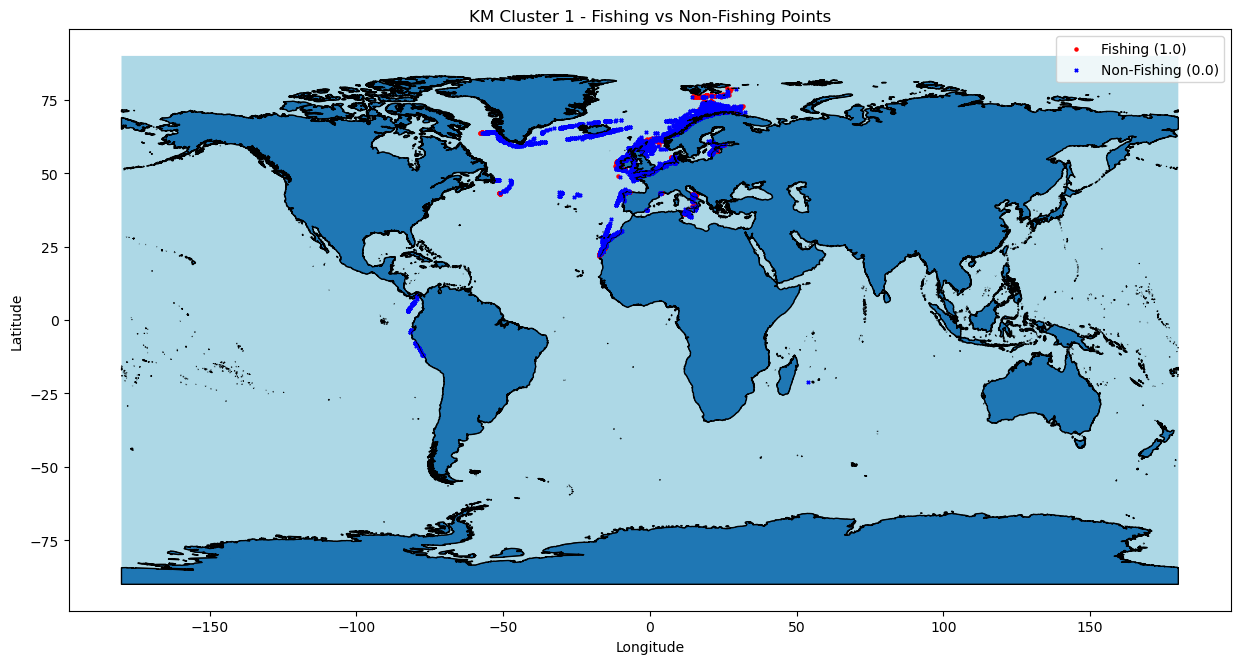

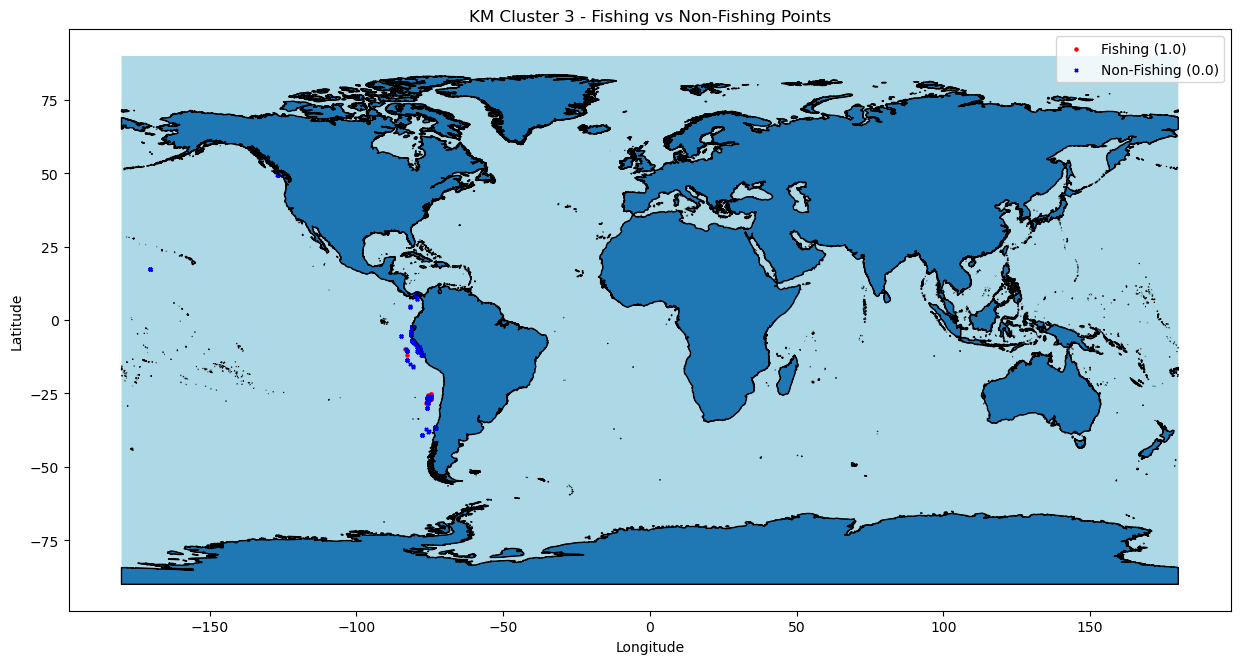

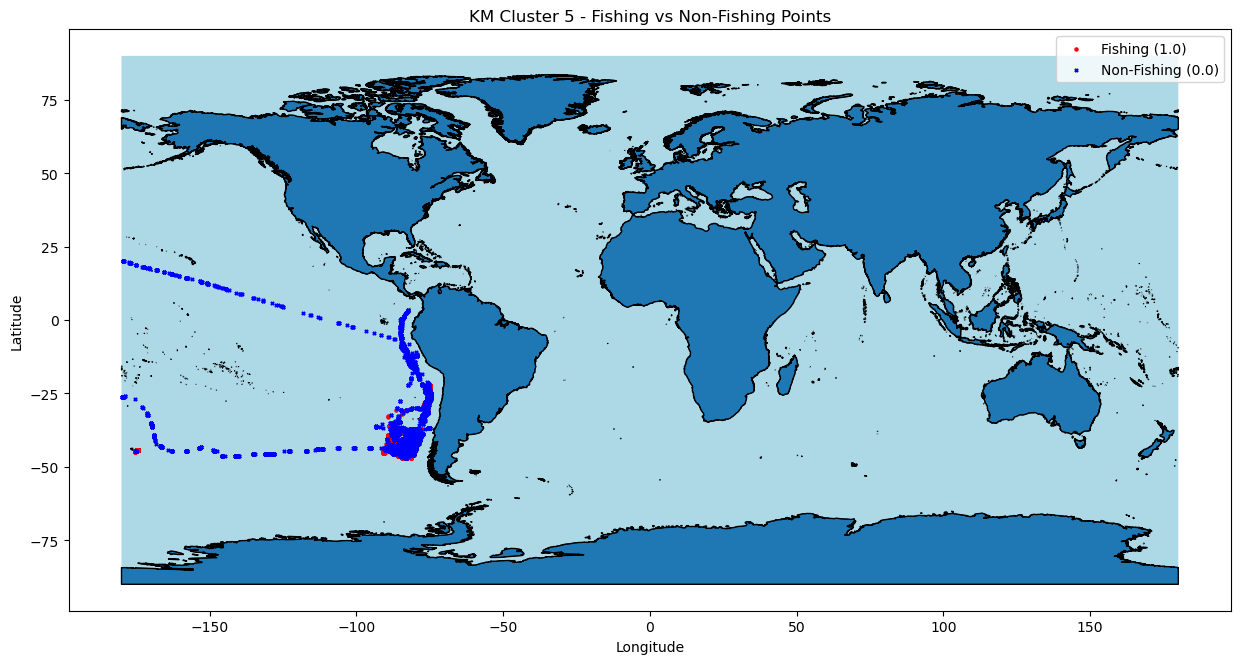

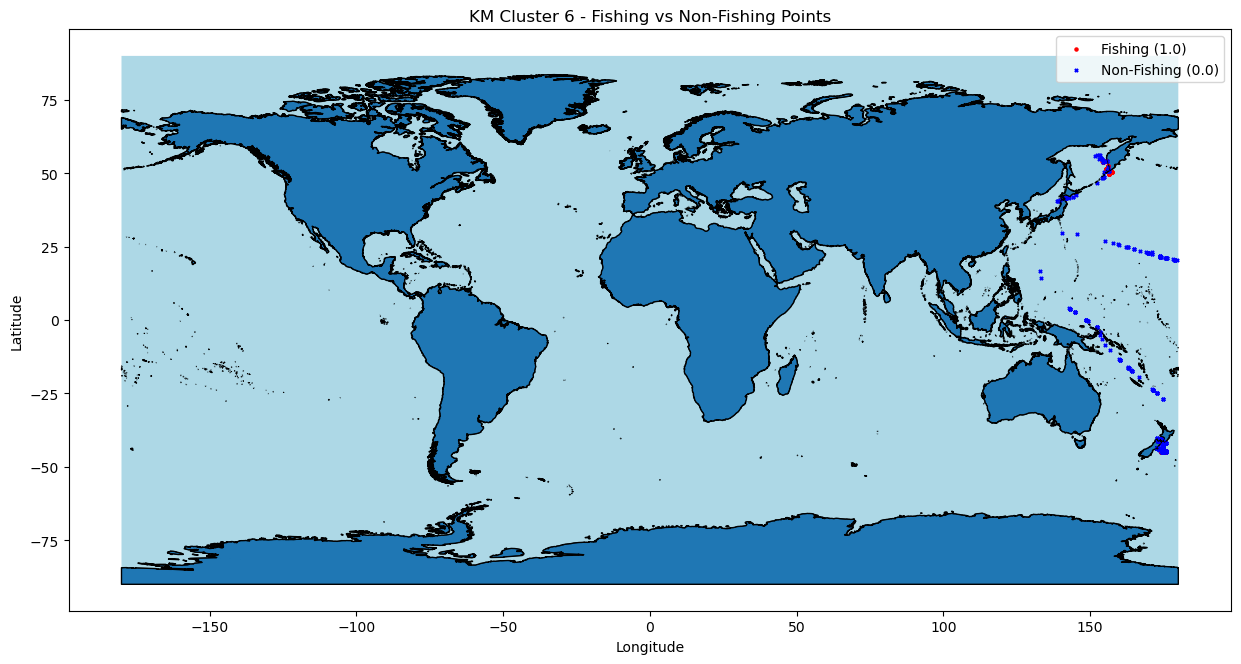

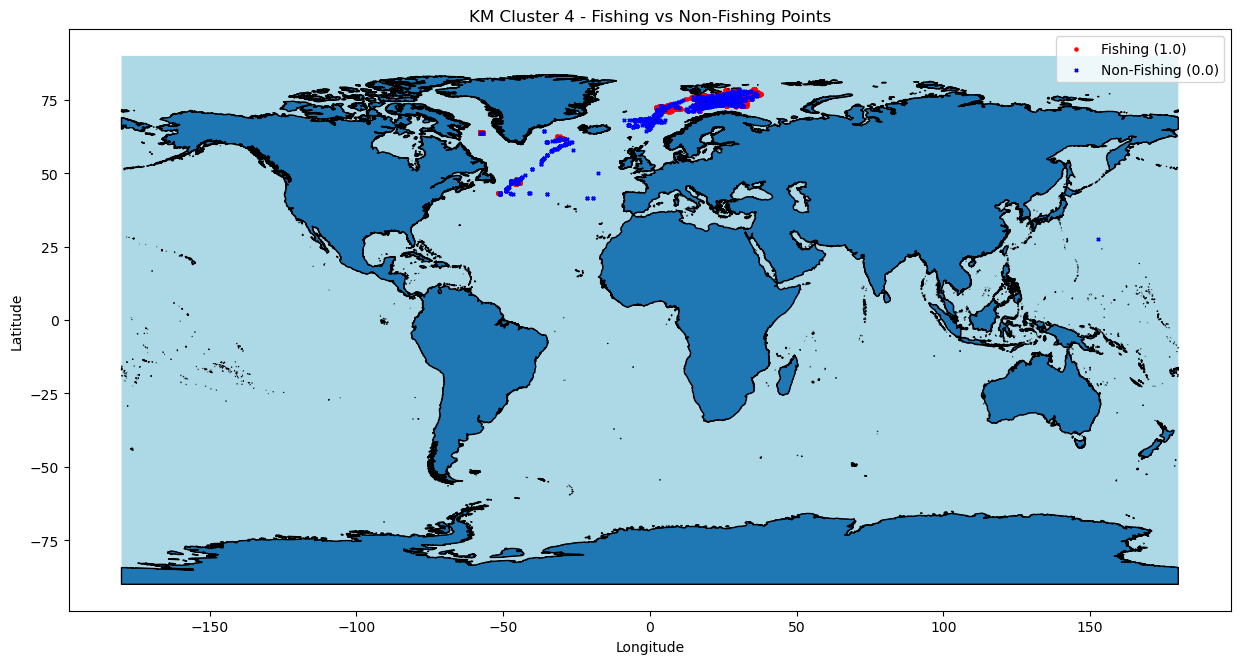

In [119]:

# Get the unique clusters (exclude noise if needed, i.e., cluster == -1)
unique_clusters_km = train_set['kmeans_cluster'].unique()

# Convert the DataFrame to a GeoDataFrame using the latitude and longitude for geometry
train_set_gdf = gpd.GeoDataFrame(train_set, 
                                 geometry=gpd.points_from_xy(train_set['lon'], train_set['lat']),
                                 crs="EPSG:4326")  # WGS84 coordinate system

# Plot each cluster in a separate map
for cluster in unique_clusters_km:

    cluster_gdf = train_set_gdf[train_set_gdf['kmeans_cluster'] == cluster]
        
    # Create a new plot for each cluster
    fig, ax = plt.subplots(figsize=(15, 10))
        
    # Plot ocean and land (optional layers)
    ocean.plot(ax=ax, color='lightblue')
    land.plot(ax=ax, edgecolor='black')
    minor_islands.plot(ax=ax, color='green', edgecolor='black')
    coastlines.plot(ax=ax, color='black', linewidth=0.5)
        
    # Plot is_fishing == 1 in red
    cluster_gdf[cluster_gdf['is_fishing'] == 1].plot(ax=ax, marker='o', color='red', markersize=5, label='Fishing (1.0)', linestyle='None')
        
    # Plot is_fishing == 0 in blue
    cluster_gdf[cluster_gdf['is_fishing'] == 0].plot(ax=ax, marker='x', color='blue', markersize=5, label='Non-Fishing (0.0)', linestyle='None')
    ax.set_aspect('equal', 'box')

    # Set title and labels
    plt.title(f'KM Cluster {cluster} - Fishing vs Non-Fishing Points')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
        
    # Add a legend
    plt.legend()
        
    # Show the plot
    plt.show()

In [123]:
# Group by kmeans_cluster and calculate the required statistics
kmeans_cluster_summary = train_set.groupby('kmeans_cluster').agg(
    total_obs=('is_fishing', 'size'),                 # Total number of observations in the cluster
    total_fishing=('is_fishing', 'sum'),              # Total number of is_fishing == 1
    avg_speed=('speed', 'mean'),                      # Average speed for each cluster
    avg_course=('course', 'mean'),                    # Average course for each cluster
    avg_distance_from_port=('distance_from_port', 'mean'),  # Average distance from port for each cluster
    avg_distance_from_shore=('distance_from_shore', 'mean'), # Average distance from shore for each cluster
).reset_index()

# Calculate the percentage of is_fishing within each cluster
kmeans_cluster_summary['fishing_percentage_in_cluster'] = (kmeans_cluster_summary['total_fishing'] / kmeans_cluster_summary['total_obs']) * 100

# Calculate the overall percentage of is_fishing in the cluster out of all is_fishing
total_fishing_obs = train_set['is_fishing'].sum()
kmeans_cluster_summary['overall_fishing_percentage'] = (kmeans_cluster_summary['total_fishing'] / total_fishing_obs) * 100

print(kmeans_cluster_summary)

   kmeans_cluster  total_obs  total_fishing  avg_speed  avg_course  \
0               0      53622        13544.0   1.004996  275.260798   
1               1      14251         4694.0  10.586282  172.972360   
2               2      37399        12567.0   1.408326   61.040386   
3               3       5793           68.0   0.554549  200.763439   
4               4      14670        12936.0   4.007614  168.790975   
5               5      13124         7383.0   7.039835  178.883984   
6               6       2788          805.0   4.442683  110.319189   

   avg_distance_from_port  avg_distance_from_shore  \
0            5.074266e+04             24345.438170   
1            1.648904e+05             97133.639433   
2            6.755356e+04             31800.479218   
3            2.290131e+04             16671.593870   
4            1.248515e+06            745617.374624   
5            9.481387e+05            732290.829619   
6            1.347502e+05             97105.946633   

   fis

## General Observations:

- **Cluster 1**: Contains the most active fishing vessels (87.5% fishing), which are far from port and operating at moderate speeds, suggesting deep-sea fishing activities.

- **Cluster 4**: Also represents deep-sea fishing, but with a lower percentage of fishing activity (54.5%) and higher speeds, suggesting vessels are more mobile, possibly alternating between fishing and travel.

- **Clusters 0 and 3**: Represent a mix of fishing and non-fishing activities, with low speeds indicating that vessels are close to shore or stationary. These clusters may capture vessels near port or in coastal fishing zones.

- **Cluster 5**: Represents vessels near port, with little fishing activity. Their very low speed indicates stationary operations, likely unrelated to active fishing.

- **Cluster 2**: Represents vessels in transit at higher speeds, suggesting movement between fishing areas or ports.

- **Cluster 6**: Shows moderate fishing and speed, likely representing near-shore fishing or travel.


Random Forest (makes no assumption regarding underlying data structure and can capture complex

In [57]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define features (X) and labels (y) from train_set
X = train_set[['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore']].values
y = train_set['is_fishing'].values

y_test = test_set['is_fishing'].values
x_test = test_set[['lat', 'lon', 'speed', 'course', 'distance_from_port','distance_from_shore']].values

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],            # Number of trees
    'max_depth': [10, 20],                 # Max depth of each tree
    'min_samples_split': [2, 5],           # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2],            # Minimum samples required to be a leaf node
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform GridSearchCV with TimeSeriesSplit as the cross-validation method
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search.fit(X, y)

# Get the best hyperparameters from GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Get the best estimator (model) from GridSearchCV
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(x_test)

# Evaluate the model on the test set
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")



Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   8.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  14.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  17.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  19.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   7.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.5s
[CV] END max_depth=10, min_sam

In [81]:
# Get feature importance rankings from the best Random Forest model
feature_importances = best_rf.feature_importances_

# Create a DataFrame to display feature rankings
features = ['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore']
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance (highest to lowest)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature rankings
print("\nFeature Importance Rankings (No Lag Variables):")
print(importance_df)


Feature Importance Rankings:
               Feature  Importance
2                speed    0.375740
5  distance_from_shore    0.260556
4   distance_from_port    0.160871
0                  lat    0.119544
1                  lon    0.065977
3               course    0.017312


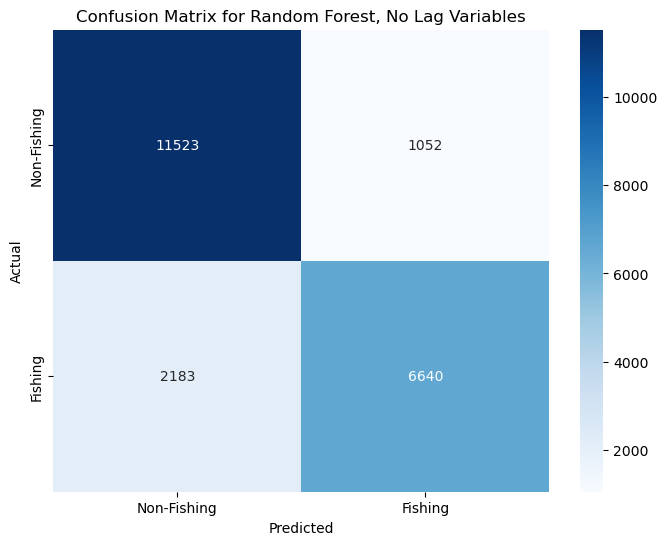

In [125]:
 # Plot Confusion Matrix for RF without lag variables
conf_matrix_rf_no_lag = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_no_lag, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fishing', 'Fishing'], yticklabels=['Non-Fishing', 'Fishing'])
plt.title('Confusion Matrix for Random Forest, No Lag Variables')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [95]:

# Define features (X) and labels (y) from train_set
X_lag = train_set[['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore', 'lag_speed','lag_course','lag_distance_from_port', 'lag_distance_from_shore']].values

x_test_lag = test_set[['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore', 'lag_speed','lag_course','lag_distance_from_port', 'lag_distance_from_shore']].values


# Initialize the Random Forest classifier
rf_lag = RandomForestClassifier(random_state=42)

# param grid is already defined . . . 

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Perform GridSearchCV with TimeSeriesSplit as the cross-validation method
grid_search_lag = GridSearchCV(estimator=rf_lag, param_grid=param_grid, 
                           cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model using GridSearchCV
grid_search_lag.fit(X_lag, y)

# Get the best hyperparameters from GridSearchCV
print(f"Best Hyperparameters: {grid_search_lag.best_params_}")

# Get the best estimator (model) from GridSearchCV
best_rf_lag = grid_search_lag.best_estimator_

# Predict on the test set
y_pred_lag = best_rf_lag.predict(x_test_lag)

# Evaluate the model on the test set
print(f"Accuracy: {accuracy_score(y_test, y_pred_lag)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_lag)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_lag)}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  18.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  22.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  11.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  34.3s
[CV] END max_depth=10, min_sam

/opt/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.8756893167585755
Confusion Matrix:
[[11453  1122]
 [ 1538  7285]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.90     12575
         1.0       0.87      0.83      0.85      8823

    accuracy                           0.88     21398
   macro avg       0.87      0.87      0.87     21398
weighted avg       0.88      0.88      0.88     21398



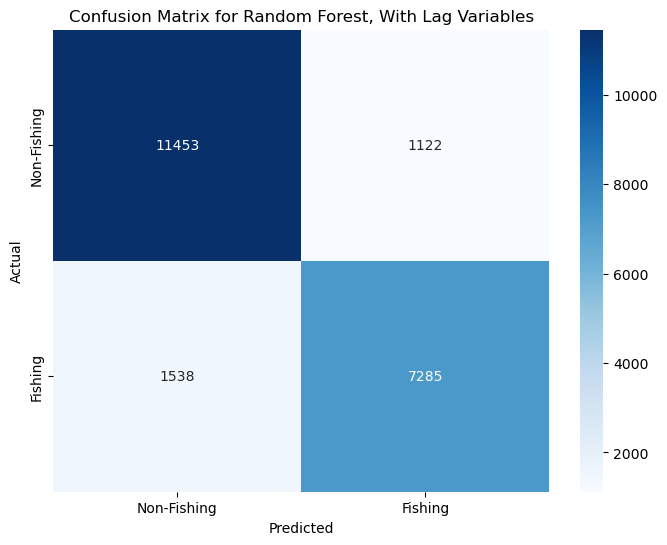

In [129]:
 # Plot Confusion Matrix for RF without lag variables
conf_matrix_rf_lag = confusion_matrix(y_test, y_pred_lag)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_lag, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fishing', 'Fishing'], yticklabels=['Non-Fishing', 'Fishing'])
plt.title('Confusion Matrix for Random Forest, With Lag Variables')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [85]:

# Get feature importance rankings from the best Random Forest model
feature_importances_lag = best_rf_lag.feature_importances_

# Create a DataFrame to display feature rankings
features_lag = ['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore', 'lag_speed', 'lag_course', 'lag_distance_from_port', 'lag_distance_from_shore']
importance_df_lag = pd.DataFrame({
    'Feature': features_lag,
    'Importance': feature_importances_lag
})

# Sort the DataFrame by importance (highest to lowest)
importance_df_lag = importance_df_lag.sort_values(by='Importance', ascending=False)

# Display the feature rankings
print("\nFeature Importance Rankings (W/ Lag Variables):")
print(importance_df_lag)


Feature Importance Rankings (W/ Lag Variables):
                   Feature  Importance
6                lag_speed    0.310016
2                    speed    0.215411
9  lag_distance_from_shore    0.169441
5      distance_from_shore    0.087976
0                      lat    0.066467
8   lag_distance_from_port    0.048751
1                      lon    0.046742
4       distance_from_port    0.039369
7               lag_course    0.008396
3                   course    0.007433


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.576529 to fit



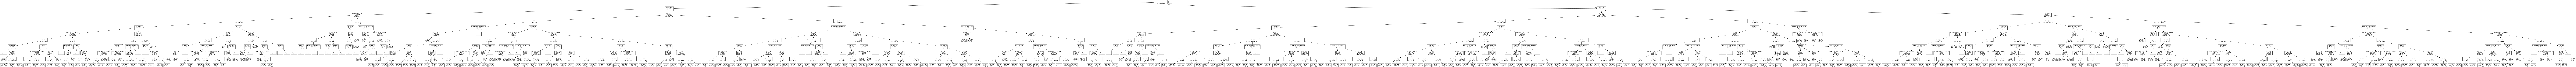

In [89]:
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
dot_data = export_graphviz(best_rf_lag.estimators_[0], out_file=None, feature_names=features_lag)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Linear SVM

Initializing TimeSeriesSplit with k = 5
Initializing Linear SVM with max_iter=10000 and class_weight='balanced'
Tuning C with values: [7.8125e-03 1.5625e-02 3.1250e-02 6.2500e-02 1.2500e-01 2.5000e-01
 5.0000e-01 1.0000e+00 2.0000e+00 4.0000e+00 8.0000e+00]
Starting GridSearchCV...
Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END .......................C=0.0078125;, score=0.628 total time=   0.1s
[CV 1/5] END ........................C=0.015625;, score=0.629 total time=   0.1s
[CV 3/5] END .......................C=0.0078125;, score=0.530 total time=   0.2s
[CV 3/5] END ........................C=0.015625;, score=0.529 total time=   0.3s
[CV 4/5] END .......................C=0.0078125;, score=0.756 total time=   0.4s
[CV 2/5] END .......................C=0.0078125;, score=0.732 total time=   0.4s
[CV 5/5] END .......................C=0.0078125;, score=0.676 total time=   0.4s
[CV 1/5] END .........................C=0.03125;, score=0.623 total time=   0.1s
[CV 2/5]

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5] END .............................C=8.0;, score=0.533 total time=   0.6s
[CV 2/5] END .............................C=8.0;, score=0.731 total time=   1.0s
[CV 4/5] END .............................C=8.0;, score=0.741 total time=   0.9s
[CV 5/5] END .............................C=8.0;, score=0.676 total time=   0.5s
Best hyperparameters found: {'C': 0.0078125}
Predicting on the test set...
Evaluating performance on the test set...
Accuracy on test set: 0.7915693055425741
Confusion Matrix on test set:
[[11347  1228]
 [ 3232  5591]]
Classification Report on test set:
              precision    recall  f1-score   support

         0.0       0.78      0.90      0.84     12575
         1.0       0.82      0.63      0.71      8823

    accuracy                           0.79     21398
   macro avg       0.80      0.77      0.78     21398
weighted avg       0.80      0.79      0.79     21398



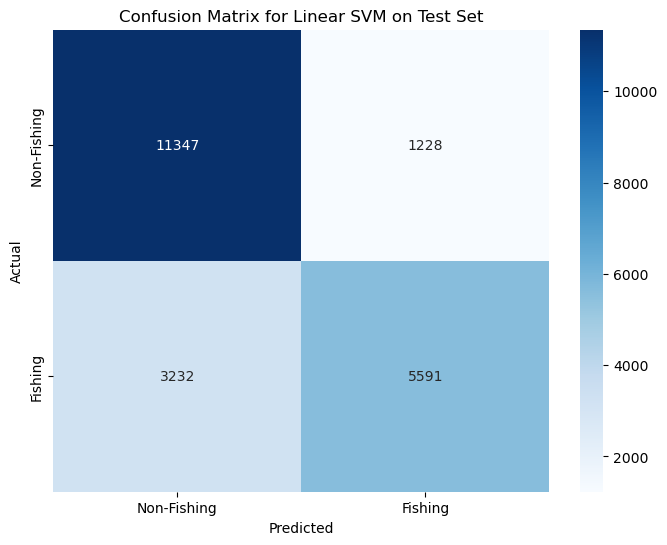

In [61]:
def evaluate_and_tune_svm_linear(x, y, k, x_test, y_test):
    # Time Series Split for cross-validation
    print("Initializing TimeSeriesSplit with k =", k)
    tscv = TimeSeriesSplit(n_splits=k)
    
    # Define the model (Linear SVM)
    print("Initializing Linear SVM with max_iter=10000 and class_weight='balanced'")
    SVM_linear = LinearSVC(max_iter=10000, dual=False, class_weight='balanced')
    
    # Define the parameter grid for tuning C
    tune_grid = {'C': 2.0 ** np.arange(-7, 4)}
    print(f"Tuning C with values: {tune_grid['C']}")
    
    # Grid search with TimeSeriesSplit for cross-validation
    print("Starting GridSearchCV...")
    grid_search = GridSearchCV(SVM_linear, param_grid=tune_grid, n_jobs=-2, cv=tscv, scoring='accuracy', verbose=3)
    grid_search.fit(x, y)  # Fit on the training data
    
    # Get the best linear model after tuning
    best_linear_model = grid_search.best_estimator_
    print(f"Best hyperparameters found: {grid_search.best_params_}")
    
    # Predict on the test set
    print("Predicting on the test set...")
    y_pred_lag = best_linear_model.predict(x_test)

    # Evaluate the model on the test set
    print("Evaluating performance on the test set...")
    accuracy = accuracy_score(y_test, y_pred_lag)
    conf_matrix = confusion_matrix(y_test, y_pred_lag)
    class_report = classification_report(y_test, y_pred_lag)
    
    # Print the evaluation metrics
    print(f"Accuracy on test set: {accuracy}")
    print(f"Confusion Matrix on test set:\n{conf_matrix}")
    print(f"Classification Report on test set:\n{class_report}")
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fishing', 'Fishing'], yticklabels=['Non-Fishing', 'Fishing'])
    plt.title('Confusion Matrix for Linear SVM on Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Return the best parameters and test set results
    results = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'fitted_model': best_linear_model
    }
    
    return results


# Train the model:
results = evaluate_and_tune_svm_linear(X_lag, y, k=5, x_test=x_test_lag, y_test=y_test)

Feature Importance:
                           Importance
course                  -5.593495e-04
lag_course              -5.577445e-04
lat                     -6.898057e-05
lon                      4.972789e-05
speed                    4.346061e-06
lag_speed                4.104980e-06
distance_from_port       5.241652e-07
lag_distance_from_port   2.582463e-07
distance_from_shore     -1.793454e-07
lag_distance_from_shore  1.337231e-07


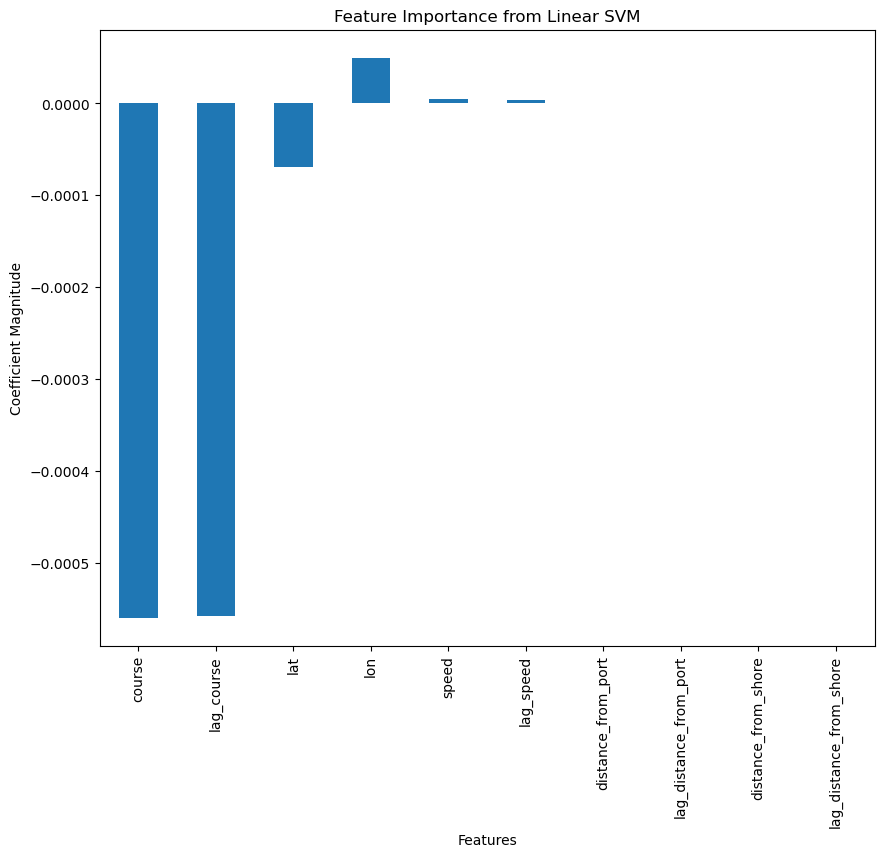

In [97]:
best_linear_model = results['fitted_model']

# Coefficients of the best model
coef = best_linear_model.coef_.flatten()  # Flatten the coefficients if they are in a 2D array
feature_names = ['lat', 'lon', 'speed', 'course', 'distance_from_port', 'distance_from_shore', 'lag_speed','lag_course','lag_distance_from_port', 'lag_distance_from_shore']

# Creating a DataFrame for feature importance with names
feature_importance = pd.DataFrame(coef, index=feature_names, columns=['Importance'])

# Sort features by absolute importance
feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)

# Print the sorted feature importances
print("Feature Importance:")
print(feature_importance)

# Plotting the feature importance for visualization
plt.figure(figsize=(10, 8))
feature_importance['Importance'].plot(kind='bar')
plt.title('Feature Importance from Linear SVM')
plt.xlabel('Features')
plt.ylabel('Coefficient Magnitude')
plt.show()

Starting Polynomial SVM evaluation and tuning...
Initializing TimeSeriesSplit with k = 2
Initializing Polynomial SVM
Tuning with parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3], 'coef0': [0.0]}
Starting GridSearchCV...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ........C=0.1, coef0=0.0, degree=3;, score=0.297 total time=11.6min
[CV 1/2] END ..........C=1, coef0=0.0, degree=3;, score=0.298 total time=11.8min


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/2] END ........C=0.1, coef0=0.0, degree=2;, score=0.294 total time=11.9min
[CV 1/2] END ..........C=1, coef0=0.0, degree=2;, score=0.294 total time=12.2min
[CV 1/2] END .........C=10, coef0=0.0, degree=3;, score=0.297 total time=12.5min
[CV 1/2] END .........C=10, coef0=0.0, degree=2;, score=0.296 total time=12.8min
[CV 2/2] END ..........C=1, coef0=0.0, degree=3;, score=0.544 total time=45.2min
[CV 2/2] END ........C=0.1, coef0=0.0, degree=2;, score=0.549 total time=46.2min
[CV 2/2] END ..........C=1, coef0=0.0, degree=2;, score=0.550 total time=49.3min
[CV 2/2] END .........C=10, coef0=0.0, degree=2;, score=0.548 total time=39.0min
[CV 2/2] END ........C=0.1, coef0=0.0, degree=3;, score=0.544 total time=51.4min
[CV 2/2] END .........C=10, coef0=0.0, degree=3;, score=0.542 total time=71.1min
Best hyperparameters found: {'C': 10, 'coef0': 0.0, 'degree': 2}
Predicting on the test set...
Evaluating performance on the test set...
Accuracy on test set: 0.7700252360033648
Confusion Ma

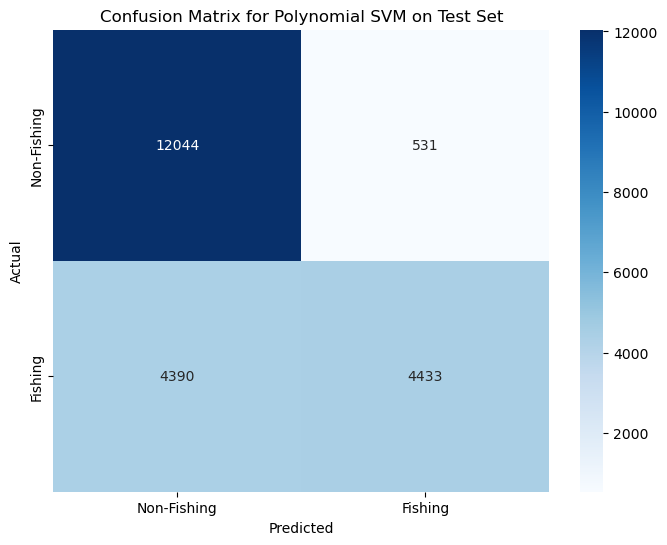

In [63]:
def evaluate_and_tune_svm_polynomial(x, y, k, x_test, y_test):
    # Time Series Split for cross-validation
    print("Initializing TimeSeriesSplit with k =", k)
    tscv = TimeSeriesSplit(n_splits=k)
    
    # Define the model (Polynomial SVM with 'poly' kernel)
    print("Initializing Polynomial SVM")
    SVM_poly = SVC(kernel='poly', class_weight='balanced')
    
    # Define the parameter grid for tuning C, degree, and coef0 (coefficient for the polynomial kernel)
    tune_grid = {
        'C': [0.1, 1, 10],                      # Regularization parameter
        'degree': [2, 3],                    # Degree of the polynomial kernel function
        'coef0': [0.0],               # Independent term in kernel function
    }
    print(f"Tuning with parameter grid: {tune_grid}")
    
    # Grid search with TimeSeriesSplit for cross-validation
    print("Starting GridSearchCV...")
    grid_search = GridSearchCV(SVM_poly, param_grid=tune_grid, n_jobs=-1, cv=tscv, scoring='accuracy', verbose=3)
    grid_search.fit(x, y)  # Fit on the training data
    
    # Get the best polynomial SVM model after tuning
    best_poly_model = grid_search.best_estimator_
    print(f"Best hyperparameters found: {grid_search.best_params_}")
    
    # Predict on the test set
    print("Predicting on the test set...")
    y_pred_lag = best_poly_model.predict(x_test)

    # Evaluate the model on the test set
    print("Evaluating performance on the test set...")
    accuracy = accuracy_score(y_test, y_pred_lag)
    conf_matrix = confusion_matrix(y_test, y_pred_lag)
    class_report = classification_report(y_test, y_pred_lag)
    
    # Print the evaluation metrics
    print(f"Accuracy on test set: {accuracy}")
    print(f"Confusion Matrix on test set:\n{conf_matrix}")
    print(f"Classification Report on test set:\n{class_report}")
    
    # Plot Confusion Matrix
    print("Plotting confusion matrix...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fishing', 'Fishing'], yticklabels=['Non-Fishing', 'Fishing'])
    plt.title('Confusion Matrix for Polynomial SVM on Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Return the best parameters and test set results
    results = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'fitted_model': best_poly_model
    }
    
    return results

# Example usage with test set defined:
print("Starting Polynomial SVM evaluation and tuning...")
results_poly = evaluate_and_tune_svm_polynomial(X_lag, y, k=2, x_test=x_test_lag, y_test=y_test)

Starting RBF SVM evaluation and tuning...
Initializing TimeSeriesSplit with k = 2
Initializing RBF SVM
Tuning with parameter grid: {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
Starting GridSearchCV...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ..................C=1, gamma=scale;, score=0.584 total time= 8.8min
[CV 1/2] END ................C=0.1, gamma=scale;, score=0.584 total time= 9.9min
[CV 1/2] END .................C=10, gamma=scale;, score=0.582 total time= 8.2min
[CV 1/2] END .................C=0.1, gamma=auto;, score=0.383 total time=19.9min
[CV 1/2] END ...................C=1, gamma=auto;, score=0.617 total time=26.3min
[CV 2/2] END ................C=0.1, gamma=scale;, score=0.778 total time=27.5min
[CV 2/2] END ..................C=1, gamma=scale;, score=0.774 total time=31.1min
[CV 2/2] END .................C=10, gamma=scale;, score=0.775 total time=24.1min
[CV 1/2] END ..................C=10, gamma=auto;, score=0.617 total time=25.1min
[CV 2/2

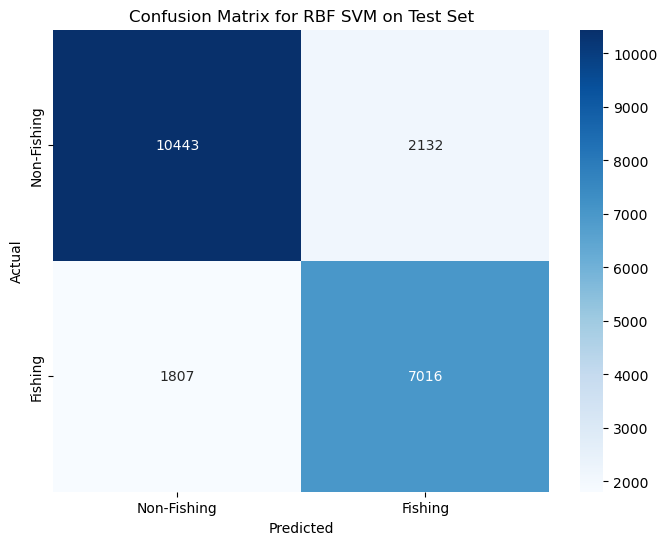

In [65]:
def evaluate_and_tune_svm_rbf(x, y, k, x_test, y_test):
    # Time Series Split for cross-validation
    print("Initializing TimeSeriesSplit with k =", k)
    tscv = TimeSeriesSplit(n_splits=k)
    
    # Define the model (SVM with 'rbf' kernel)
    print("Initializing RBF SVM")
    SVM_rbf = SVC(kernel='rbf', class_weight='balanced')
    
    # Define the parameter grid for tuning C and gamma (which controls the influence of points)
    tune_grid = {
        'C': [0.1, 1, 10],          # Regularization parameter
        'gamma': ['scale', 'auto']   # Kernel coefficient
        
    }
    print(f"Tuning with parameter grid: {tune_grid}")
    
    # Grid search with TimeSeriesSplit for cross-validation
    print("Starting GridSearchCV...")
    grid_search = GridSearchCV(SVM_rbf, param_grid=tune_grid, n_jobs=-1, cv=tscv, scoring='accuracy', verbose=3)
    grid_search.fit(x, y)  # Fit on the training data
    
    # Get the best RBF SVM model after tuning
    best_rbf_model = grid_search.best_estimator_
    print(f"Best hyperparameters found: {grid_search.best_params_}")
    
    # Predict on the test set
    print("Predicting on the test set...")
    y_pred_lag = best_rbf_model.predict(x_test)

    # Evaluate the model on the test set
    print("Evaluating performance on the test set...")
    accuracy = accuracy_score(y_test, y_pred_lag)
    conf_matrix = confusion_matrix(y_test, y_pred_lag)
    class_report = classification_report(y_test, y_pred_lag)
    
    # Print the evaluation metrics
    print(f"Accuracy on test set: {accuracy}")
    print(f"Confusion Matrix on test set:\n{conf_matrix}")
    print(f"Classification Report on test set:\n{class_report}")
    
    # Plot Confusion Matrix
    print("Plotting confusion matrix...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fishing', 'Fishing'], yticklabels=['Non-Fishing', 'Fishing'])
    plt.title('Confusion Matrix for RBF SVM on Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Return the best parameters and test set results
    results = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'fitted_model': best_rbf_model
    }
    
    return results

print("Starting RBF SVM evaluation and tuning...")
results_rbf = evaluate_and_tune_svm_rbf(X_lag, y, k=2, x_test=x_test_lag, y_test=y_test)
